# Bayesian Marketing Mix Modeling with pymc3

Slava Kisilevich
kisilevich.slava@gmail.com

In [1]:
%load_ext autoreload
%autoreload 2

In [41]:
import pandas as pd
import numpy as np
import math
import sys
import os


pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True)
#suppress exponential notation, define an appropriate float formatter
#specify stdout line width and let pretty print do the work
np.set_printoptions(suppress=True, formatter={'float_kind':'{:16.3f}'.format}, linewidth=130)

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18
import seaborn as sns

from scipy.stats.mstats import mquantiles

from plotnine import *

#from numerize import numerize

In [3]:
import pymc3 as pm

import arviz as az


import theano
import theano.tensor as tt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

In [5]:
from scipy import optimize

In [6]:
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [7]:
START_ANALYSIS_INDEX = 52
END_ANALYSIS_INDEX = 144

## Data

In [10]:
data = pd.read_csv("./data/data_raw_2015-11-23__2019-11-11.csv", parse_dates = ["DATE"])
data.columns = [c.lower() if c in ["DATE"] else c for c in data.columns]
data

,date,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter
0,2015-11-23,2754371.66667,167687.60000,0,95463.66667,72903852.71259,0.00000,0,8125009,228213.98744,na,19401.65385
1,2015-11-30,2584276.66667,214600.90000,0,0.00000,16581099.54533,29511.71546,31000,7901549,34258.57351,na,14791.00000
2,2015-12-07,2547386.66667,0.00000,248022,3404.00000,49954773.67047,36132.35896,28400,8300197,127691.26133,na,14544.00000
3,2015-12-14,2875220.00000,625877.30000,0,132600.00000,31649297.02879,36804.21096,31900,8122883,84014.72031,na,2800.00000
4,2015-12-21,2215953.33333,0.00000,520005,0.00000,8802269.47875,28401.74407,27100,7105985,20687.47816,na,15478.00000
...,...,...,...,...,...,...,...,...,...,...,...,...
203,2019-10-14,2456240.00000,0.00000,60433,153723.66667,0.00000,152840.32341,112100,7612762,0.00000,na,28157.00000
204,2019-10-21,2182825.00000,154917.60000,0,0.00000,56881962.23521,103680.04782,103700,6701667,133624.57552,na,10644.00000
205,2019-10-28,2377706.66667,21982.50000,14094,17476.00000,0.00000,138387.70414,114700,7688920,0.00000,na,9597.00000
206,2019-11-04,2732825.00000,22453.00000,0,24051.33333,0.00000,151707.99046,134100,8815710,0.00000,na,90189.00000


In [11]:
holidays = pd.read_csv("./data/prophet_holidays_daily.csv", parse_dates = ["ds"])
holidays["begin_week"] = holidays["ds"].dt.to_period('W-SUN').dt.start_time
#combine same week holidays into one holiday
holidays_weekly = holidays.groupby(["begin_week", "country", "year"], as_index = False).agg({'holiday':'#'.join, 'country': 'first', 'year': 'first'}).rename(columns = {'begin_week': 'ds'})
holidays_weekly_de = holidays_weekly.query("(country == 'DE')").copy()
holidays_weekly_de

,ds,holiday,country,year
12,1994-12-26,Neujahr,DE,1995
183,1995-04-10,Karfreitag,DE,1995
222,1995-04-17,Ostermontag,DE,1995
270,1995-05-01,Erster Mai,DE,1995
346,1995-05-22,Christi Himmelfahrt,DE,1995
...,...,...,...,...
35445,2044-05-23,Christi Himmelfahrt,DE,2044
35481,2044-06-06,Pfingstmontag,DE,2044
35646,2044-10-03,Tag der Deutschen Einheit,DE,2044
35781,2044-12-19,Erster Weihnachtstag,DE,2044


In [12]:
prophet_data = data.rename(columns = {'revenue': 'y', 'date': 'ds'})
#add categorical into prophet
prophet_data = pd.concat([prophet_data, pd.get_dummies(prophet_data["events"], drop_first = True, prefix = "events")], axis = 1)
prophet_data

,ds,y,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter,events_event2,events_na
0,2015-11-23,2754371.66667,167687.60000,0,95463.66667,72903852.71259,0.00000,0,8125009,228213.98744,na,19401.65385,0,1
1,2015-11-30,2584276.66667,214600.90000,0,0.00000,16581099.54533,29511.71546,31000,7901549,34258.57351,na,14791.00000,0,1
2,2015-12-07,2547386.66667,0.00000,248022,3404.00000,49954773.67047,36132.35896,28400,8300197,127691.26133,na,14544.00000,0,1
3,2015-12-14,2875220.00000,625877.30000,0,132600.00000,31649297.02879,36804.21096,31900,8122883,84014.72031,na,2800.00000,0,1
4,2015-12-21,2215953.33333,0.00000,520005,0.00000,8802269.47875,28401.74407,27100,7105985,20687.47816,na,15478.00000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,2019-10-14,2456240.00000,0.00000,60433,153723.66667,0.00000,152840.32341,112100,7612762,0.00000,na,28157.00000,0,1
204,2019-10-21,2182825.00000,154917.60000,0,0.00000,56881962.23521,103680.04782,103700,6701667,133624.57552,na,10644.00000,0,1
205,2019-10-28,2377706.66667,21982.50000,14094,17476.00000,0.00000,138387.70414,114700,7688920,0.00000,na,9597.00000,0,1
206,2019-11-04,2732825.00000,22453.00000,0,24051.33333,0.00000,151707.99046,134100,8815710,0.00000,na,90189.00000,0,1


In [13]:
prophet = Prophet(yearly_seasonality=True, holidays=holidays_weekly_de)
prophet.add_regressor(name = "events_event2")
prophet.add_regressor(name = "events_na")

In [14]:
prophet.fit(prophet_data[["ds", "y", "events_event2", "events_na"]])
prophet_predict = prophet.predict(prophet_data[["ds", "y", "events_event2", "events_na"]])

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


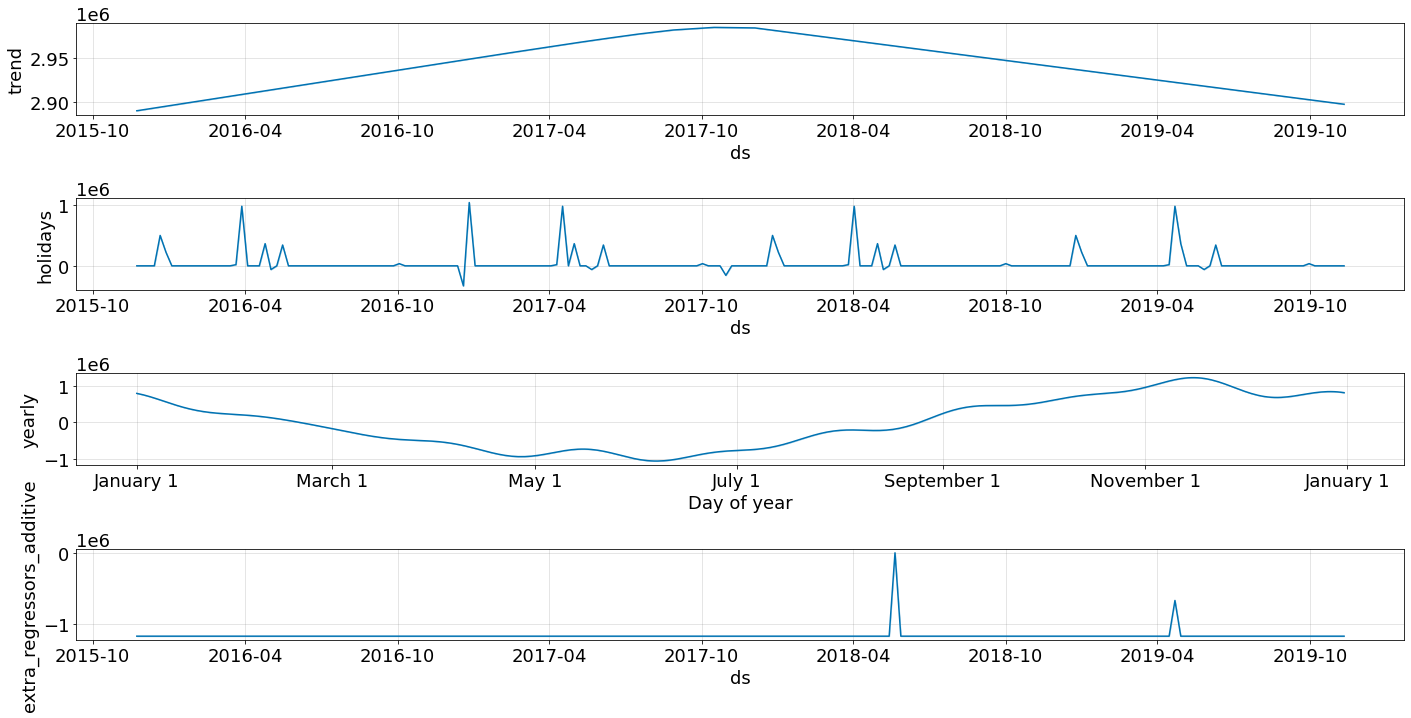

In [40]:
plot = prophet.plot_components(prophet_predict, figsize = (20, 10))

In [34]:
prophet_columns = [col for col in prophet_predict.columns if (col.endswith("upper") == False) & (col.endswith("lower") == False)]
events_numeric = prophet_predict[prophet_columns].filter(like = "events_").sum(axis = 1)


final_data = data.copy()
final_data["trend"] = prophet_predict["trend"]
final_data["season"] = prophet_predict["yearly"]
final_data["holiday"] = prophet_predict["holidays"]
final_data["events"] = (events_numeric - np.min(events_numeric)).values

## Non-linear parameter estimation

In [35]:
spend_to_exposure_menten_func = lambda spend, V_max, K_m: V_max * spend / (K_m + spend)
exposure_to_spend_menten_func = lambda exposure, V_max, K_m: exposure * K_m / (V_max - exposure)

In [36]:
media_exposures = ["facebook_I", "search_clicks_P"]
media_spends = ["facebook_S", "search_S"]

media_spend_exposure_df = pd.DataFrame()
for (media_exposure, media_spend) in zip(media_exposures, media_spends):
    V_max = final_data[media_exposure].values[START_ANALYSIS_INDEX : END_ANALYSIS_INDEX].max()
    K_m   = V_max / 2
    spend = final_data[media_spend].values[START_ANALYSIS_INDEX : END_ANALYSIS_INDEX]
    exposure = final_data[media_exposure].values[START_ANALYSIS_INDEX : END_ANALYSIS_INDEX]
    best_values, _ = optimize.curve_fit(f = spend_to_exposure_menten_func, xdata = spend, ydata = exposure, p0 = [V_max, K_m])
    media_spend_exposure_df = pd.concat([media_spend_exposure_df, pd.DataFrame({'spend': [media_spend], 'exposure': [media_exposure], 'V_max': [best_values[0]], 'K_m': [best_values[1]]})]).reset_index(drop = True)
    
media_spend_exposure_df

,spend,exposure,V_max,K_m
0,facebook_S,facebook_I,1288297663.56310,3164938.37724
1,search_S,search_clicks_P,751750.93339,600985.07717


In [37]:
data.iloc[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX]

,date,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter
52,2016-11-21,2964696.66667,52177.90000,271909,54698.00000,80485549.89262,0.00000,0,9029457,200462.81552,na,19401.65385
53,2016-11-28,2848525.00000,0.00000,0,31072.00000,53736753.49765,73955.95632,71500,9334174,141956.39115,na,27941.00000
54,2016-12-05,2740160.00000,106908.00000,448276,0.00000,21469926.03224,65123.98793,63000,8234498,49694.03594,na,51273.00000
55,2016-12-12,2380508.33333,0.00000,0,0.00000,29472934.60218,52768.86061,55100,7904539,90910.83720,na,19606.00000
56,2016-12-19,2230915.00000,0.00000,627975,0.00000,14122124.68989,47686.78427,51700,7127441,30356.33075,na,4453.00000
...,...,...,...,...,...,...,...,...,...,...,...,...
139,2018-07-23,1479303.33333,72966.70000,0,38795.00000,0.00000,47370.36869,51900,4606123,0.00000,na,22477.00000
140,2018-07-30,1647193.33333,0.00000,0,0.00000,0.00000,77832.99757,58100,5494567,0.00000,na,8906.00000
141,2018-08-06,2009478.33333,97811.20000,173577,54001.00000,0.00000,76885.47655,65800,6045317,0.00000,na,59318.00000
142,2018-08-13,1523443.33333,0.00000,0,0.00000,54622076.09755,0.00000,0,5035305,133522.51163,na,19401.65385


## Bayesian Marketing Mix Modeling using pymc3

In [42]:
data = final_data

<AxesSubplot:>

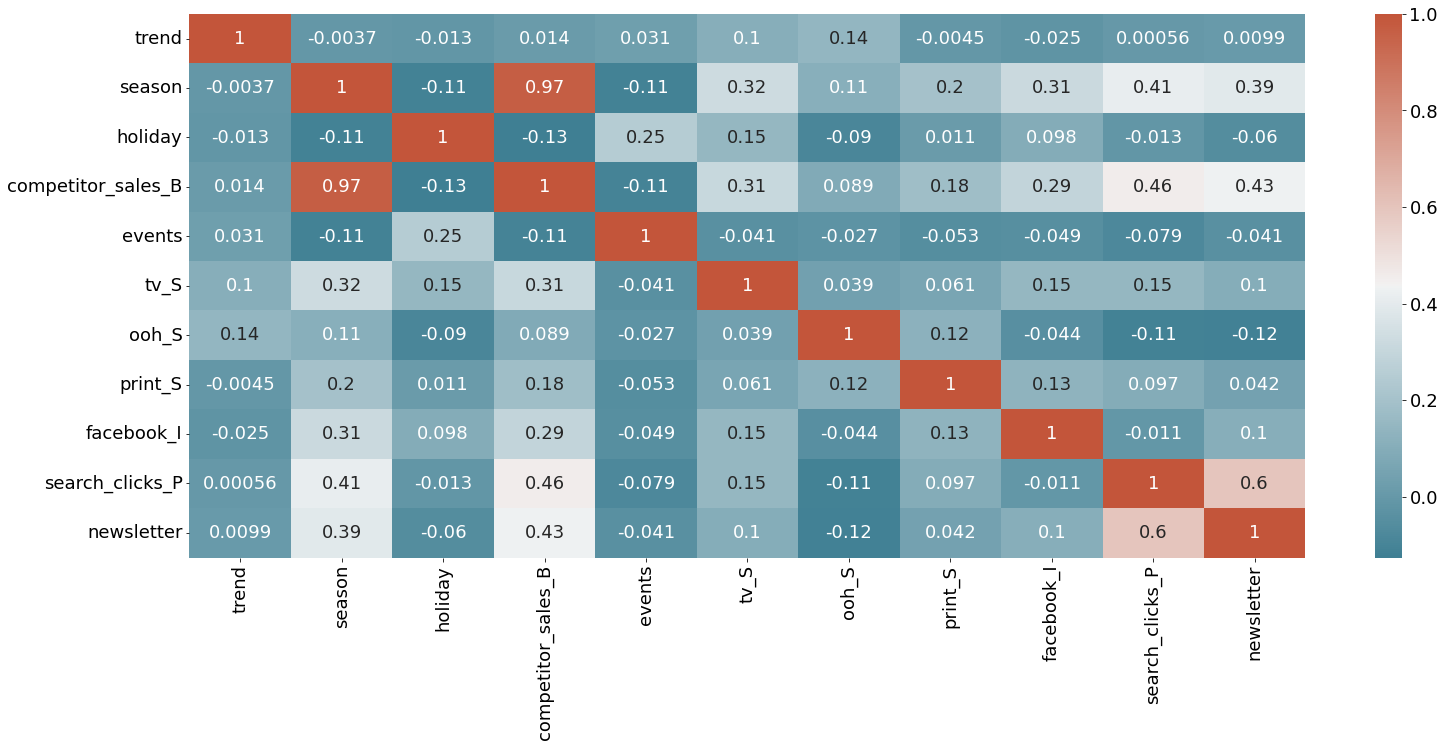

In [43]:
corr = data[["trend", "season", "holiday", "competitor_sales_B", "events", "tv_S", "ooh_S", "print_S", "facebook_I", "search_clicks_P", "newsletter"]].corr()


fig, ax = plt.subplots(figsize=(25,10))
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, annot = True, cmap = sns.diverging_palette(220, 20, as_cmap=True))

In [44]:
def adstock_geometric(x: float, theta: float):
    x_decayed = np.zeros_like(x)
    x_decayed[0] = x[0]
                               
    for xi in range(1, len(x_decayed)):
        x_decayed[xi] = x[xi] + theta * x_decayed[xi - 1]

    return x_decayed

def adstock_geometric_theano_pymc3(x, theta):
    x = tt.as_tensor_variable(x)
    #x = tt.vector("x")
    #theta = tt.scalar("theta")

    def adstock_geometric_recurrence_theano(index, input_x, decay_x, theta):
        return tt.set_subtensor(decay_x[index], tt.sum(input_x + theta * decay_x[index - 1]))

    len_observed = x.shape[0]

    x_decayed = tt.zeros_like(x)
    x_decayed = tt.set_subtensor(x_decayed[0], x[0])

    output, _ = theano.scan(
        fn = adstock_geometric_recurrence_theano, 
        sequences = [tt.arange(1, len_observed), x[1:len_observed]], 
        outputs_info = x_decayed,
        non_sequences = theta, 
        n_steps = len_observed - 1
    )
    
    return output[-1]


def saturation_hill_pymc3(x, alpha, gamma): 
    
    x_s_hill = x ** alpha / (x ** alpha + gamma ** alpha)
    
    return x_s_hill


#from https://github.com/ikatsov/tensor-house/blob/master/promotions/mediamix-bayesian.ipynb

#plots priors using the random variables
def plot_priors(variables, prior_dictionary = None):
    if isinstance(variables[0], pm.model.TransformedRV) == False and prior_dictionary is None:
        raise Exception("prior dictionary should be provided. It can be generated by sample_prior_predictive")
    cols = 2
    rows = int(math.ceil(len(variables)/cols))
    fig, ax = plt.subplots(rows, cols, figsize=(15, 3*rows))
    ax = np.reshape(ax, (-1, cols))
    for i in range(rows):
         for j in range(cols):
            vi = i*cols + j
            if vi < len(variables):
                var = variables[vi]
                if isinstance(var, pm.model.TransformedRV):
                    sns.histplot(var.random(size=10000).flatten(), kde=True, ax=ax[i, j])
                    #p.set_axis_labels(var.name)
                    ax[i, j].set_title(var.name)
                else:
                    prior = prior_dictionary[var]
                    sns.histplot(prior, kde=True, ax = ax[i, j])
                    ax[i, j].set_title(var)
    plt.tight_layout()
    
def autocorr(x):
    # from http://tinyurl.com/afz57c4
    result = np.correlate(x, x, mode='full')
    result = result / np.max(result)
    return result[result.size // 2:]

def nrmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2)) / (np.max(y_true) - np.min(y_true))


def plot_residuals(actual_vs_predicted: pd.DataFrame, figure_size = (15, 10)):
    """Residual plot

    Args:
        actual_vs_predicted (pd.DataFrame): Data Frame with three columns: date, actual, predicted
        figure_size (tuple, optional): Figure size. Defaults to (15, 10).
    """
    
    plt = ggplot(actual_vs_predicted, aes("predicted", y = "actual - predicted"))\
    + geom_point(size = 2, show_legend = True)\
    + geom_hline(yintercept = 0, linetype = "dashed")\
    + geom_smooth(se=True, method = "loess", color = "blue")\
    + ggtitle("Actuals vs. predicted response") + xlab("predicted") + ylab("residual")\
    + theme(figure_size = figure_size,
                        legend_direction='horizontal', 
                        legend_position= "bottom",
                        legend_box_spacing=0.5,
                        legend_key_size=20, 
                        legend_entry_spacing_y=10, 
                        axis_text_y=element_text(weight="bold", size = 10)
        ) 
    
    return plt   


def plot_spend_vs_effect_share(decomp_spend: pd.DataFrame, figure_size = (15, 10)):
    """Spend vs Effect Share plot

    Args:
        decomp_spend (pd.DataFrame): Data with media decompositions. The following columns should be present: media, spend_share, effect_share per media variable
        figure_size (tuple, optional): Figure size. Defaults to (15, 10).

    Example:
        decomp_spend:
        media         spend_share effect_share
        tv_S           0.31        0.44
        ooh_S          0.23        0.34
    
    Returns:
        [plotnine]: plotnine plot
    """
    
    plot_spend_effect_share = decomp_spend.melt(id_vars = ["media"], value_vars = ["spend_share", "effect_share"])

    plt = ggplot(plot_spend_effect_share, aes("media", "value", fill = "variable")) \
    + geom_bar(stat = "identity", position = "dodge") \
    + geom_text(aes(label = "value * 100", group = "variable"), color = "darkblue", position=position_dodge(width = 0.5), format_string = "{:.2f}%") \
    + coord_flip() \
    + ggtitle("Share of Spend VS Share of Effect") + ylab("") + xlab("") \
    + theme(figure_size = figure_size, 
                    legend_direction='vertical', 
                    legend_title=element_blank(),
                    legend_key_size=20, 
                    legend_entry_spacing_y=5) 
    return plt

## Dependent Treansformation is divided by 100K

In [45]:
transform_variables = ["trend",	"season", "holiday", "competitor_sales_B",	"events", "tv_S", "ooh_S", "print_S", "facebook_I", "search_clicks_P", "newsletter"]

delay_channels = ["tv_S", "ooh_S", "print_S", "facebook_I", "search_clicks_P", "newsletter"]

media_channels = ["tv_S", "ooh_S", "print_S", "facebook_I", "search_clicks_P"]

control_variables = ["trend", "season", "holiday", "competitor_sales_B", "events"]

target = "revenue"

data_transformed = data.copy()

numerical_encoder_dict = {}

for feature in transform_variables:
    scaler = MinMaxScaler()
    original = data[feature].values.reshape(-1, 1)
    transformed = scaler.fit_transform(original)
    data_transformed[feature] = transformed
    numerical_encoder_dict[feature] = scaler

dependent_transformation = None
original = data[target].values
data_transformed[target] = original / 100_000
    
response_mean = []
with pm.Model() as model_2:
    for channel_name in delay_channels:
        print(f"Delay Channels: Adding {channel_name}")
        
        x = data_transformed[channel_name].values
        
        
        
        adstock_param = pm.Beta(f"{channel_name}_adstock", 3, 3)
        saturation_gamma = pm.Beta(f"{channel_name}_gamma", 2, 2)
        saturation_alpha = pm.Gamma(f"{channel_name}_alpha", 3, 1)
        
        x_new = adstock_geometric_theano_pymc3(x, adstock_param)
        x_new_sliced = x_new[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX]
        saturation_tensor = saturation_hill_pymc3(x_new_sliced, saturation_alpha, saturation_gamma)
        
        channel_b = pm.HalfNormal(f"{channel_name}_media_coef", sd = 3)
        response_mean.append(saturation_tensor * channel_b)
        
    for control_var in control_variables:
        print(f"Control Variables: Adding {control_var}")
        
        x = data_transformed[control_var].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX]
        
        control_beta = pm.Normal(f"{control_var}_control_coef", sd = 3)
        control_x = control_beta * x
        response_mean.append(control_x)
        
    intercept = pm.Normal("intercept", np.mean(data_transformed[target].values), sd = 3)
    #intercept = pm.HalfNormal("intercept", 0, sd = 3)
        
    sigma = pm.HalfNormal("sigma", 4)
    
    likelihood = pm.Normal("outcome", mu = intercept + sum(response_mean), sd = sigma, observed = data_transformed[target].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX])
        

Delay Channels: Adding tv_S
Delay Channels: Adding ooh_S
Delay Channels: Adding print_S
Delay Channels: Adding facebook_I
Delay Channels: Adding search_clicks_P
Delay Channels: Adding newsletter
Control Variables: Adding trend
Control Variables: Adding season
Control Variables: Adding holiday
Control Variables: Adding competitor_sales_B
Control Variables: Adding events


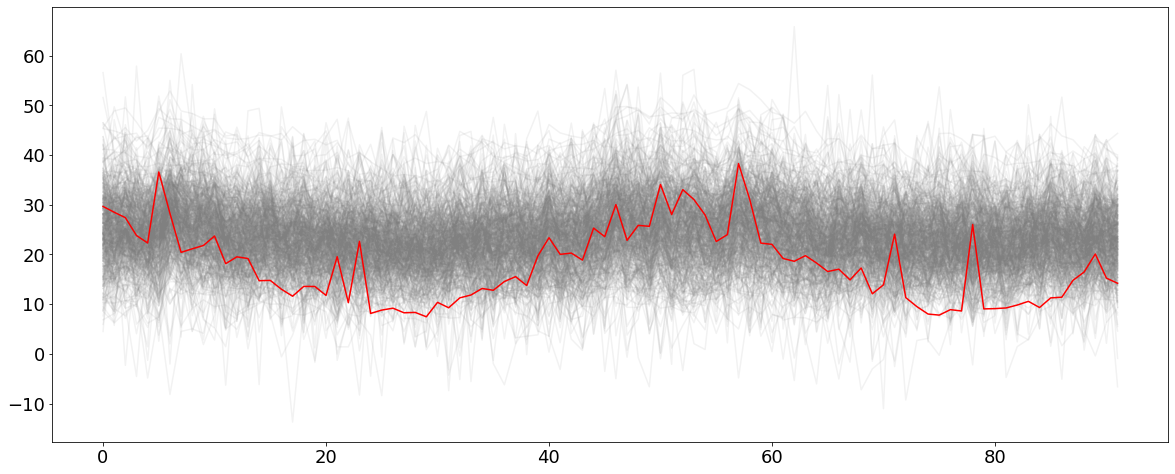

In [46]:
with model_2:
    prior_pred = pm.sample_prior_predictive()
    
fig, ax = plt.subplots(figsize = (20, 8))
_ = ax.plot(prior_pred["outcome"].T, color = "0.5", alpha = 0.1)
_ = ax.plot(data_transformed[target].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX], color = "red")

In [48]:
prior_names = [prior_name for prior_name in list(prior_pred.keys()) if (prior_name.endswith("logodds__") == False) & (prior_name.endswith("_log__") == False)]

In [49]:
len(prior_names)

32

adstock priors: 6
alpha priors: 6
gamma priors: 6
media coef priors: 6
control coef priors: 6
sigma prior: 1


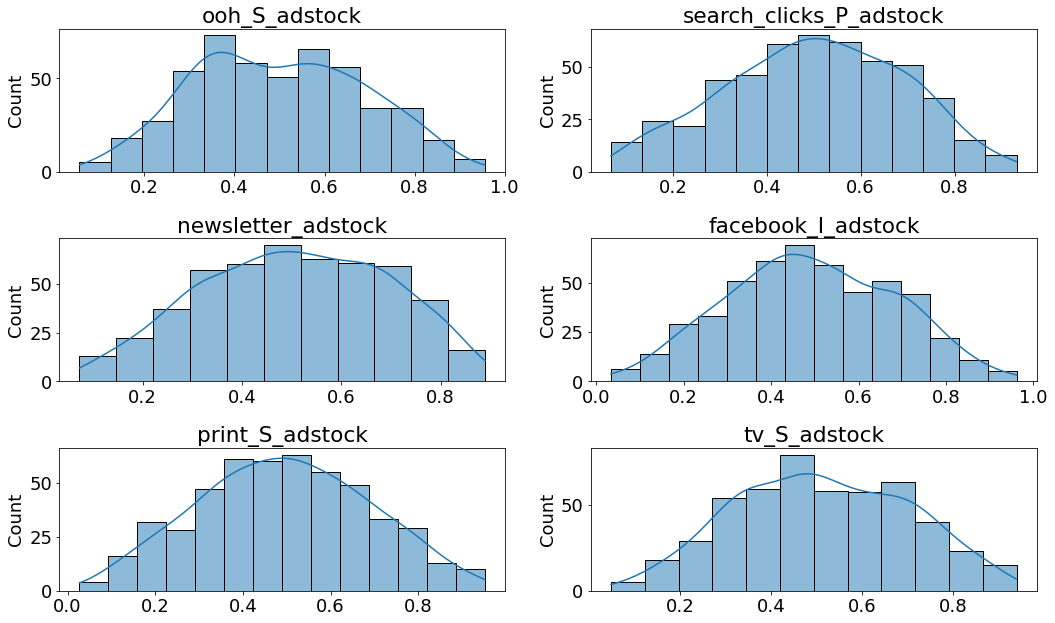

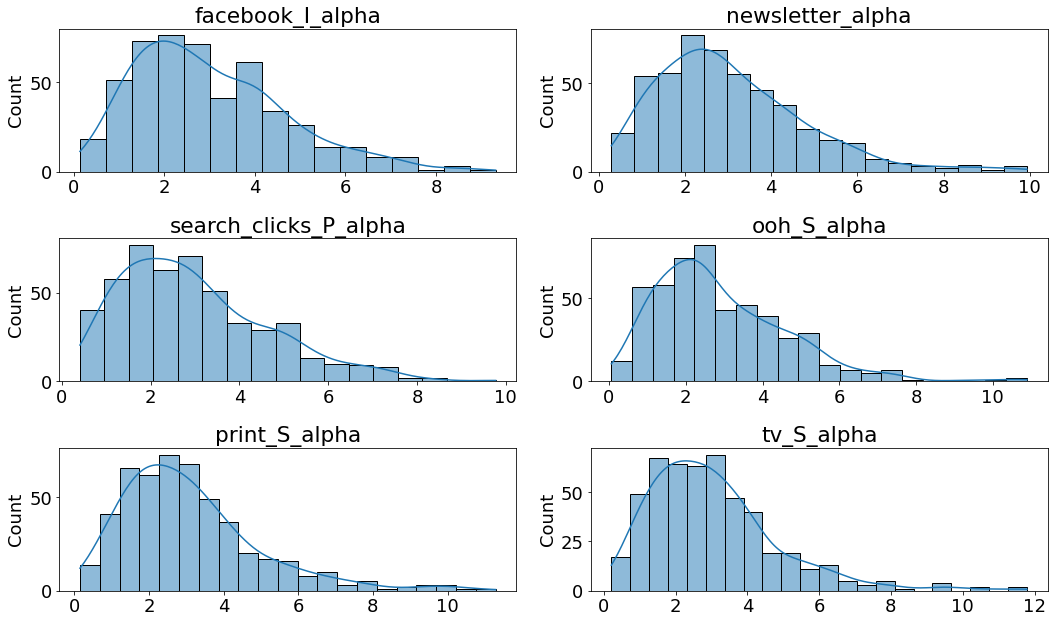

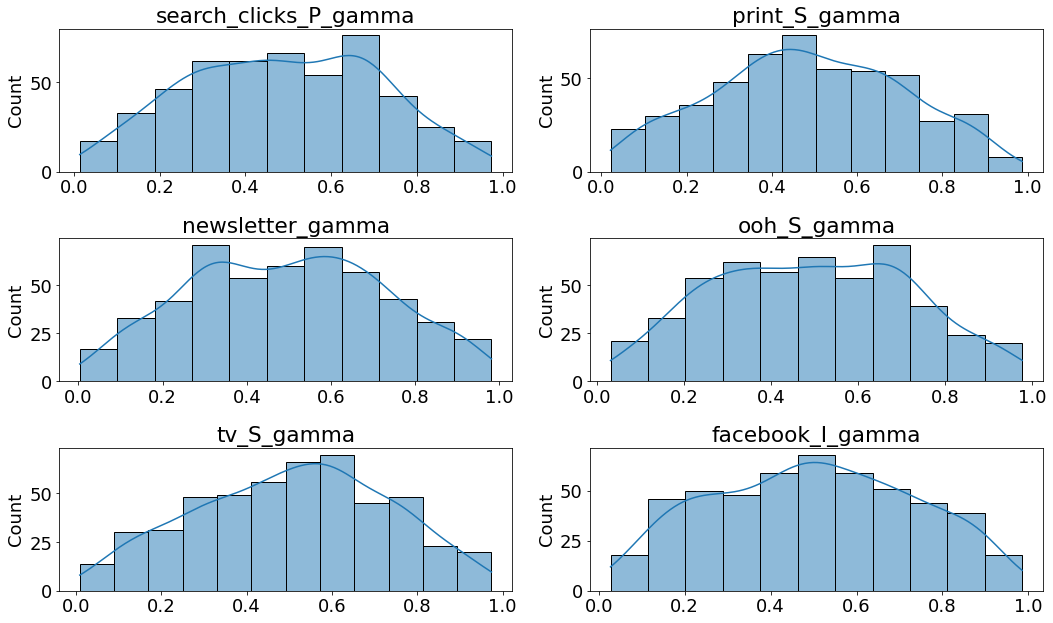

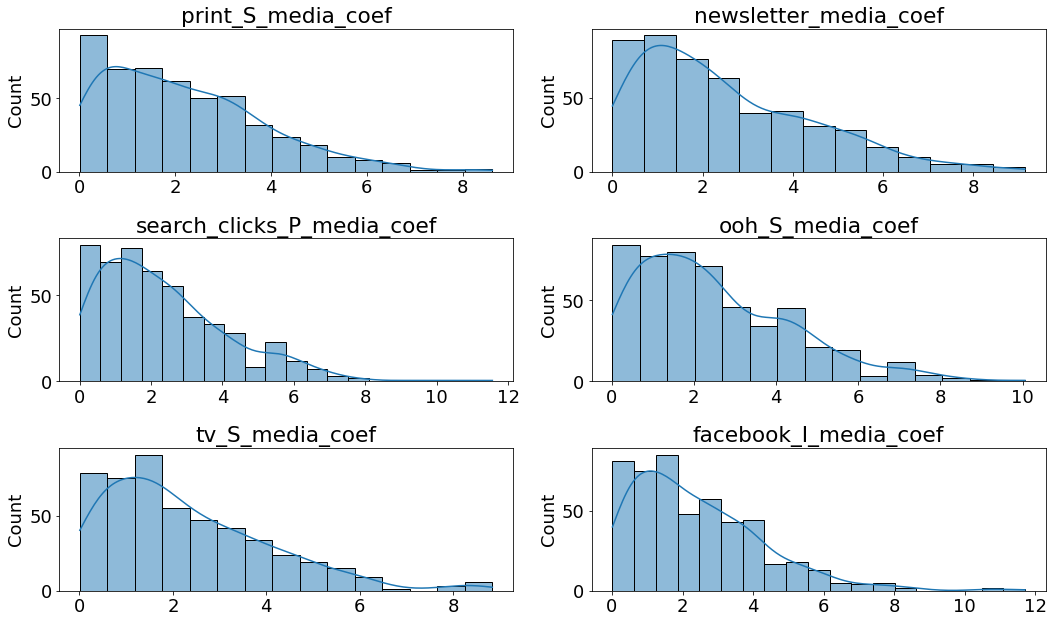

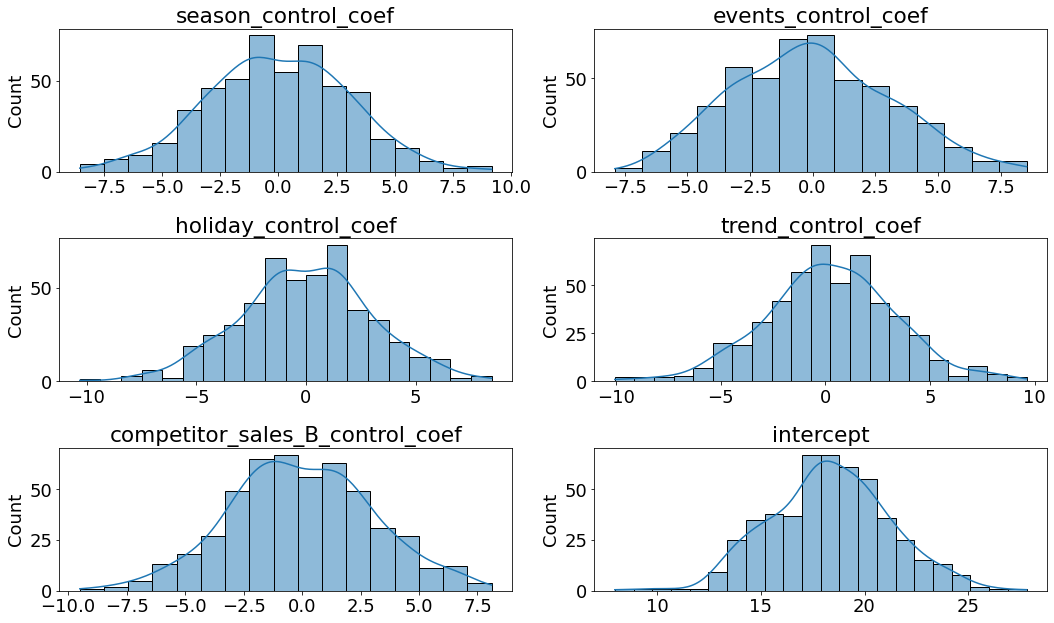

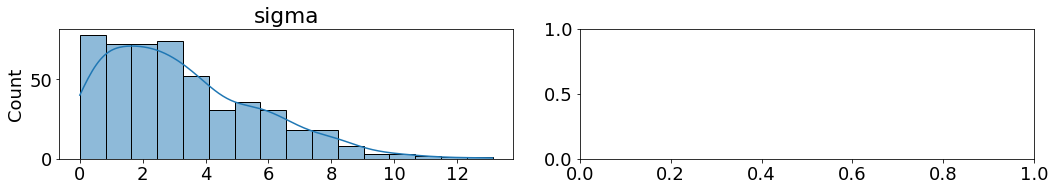

In [50]:
adstock_priors = [p for p in prior_names if p.endswith("adstock")]
plot_priors(adstock_priors, prior_pred)
print(f"adstock priors: {len(adstock_priors)}")

alpha_priors = [p for p in prior_names if p.endswith("alpha")]
plot_priors(alpha_priors, prior_pred)
print(f"alpha priors: {len(alpha_priors)}")

gamma_priors = [p for p in prior_names if p.endswith("gamma")]
plot_priors(gamma_priors, prior_pred)
print(f"gamma priors: {len(gamma_priors)}")


media_coef_priors = [p for p in prior_names if p.endswith("media_coef")]
plot_priors(media_coef_priors, prior_pred)
print(f"media coef priors: {len(media_coef_priors)}")

control_coef_priors = [p for p in prior_names if p.endswith("control_coef")] + ["intercept"]
plot_priors(control_coef_priors, prior_pred)
print(f"control coef priors: {len(control_coef_priors)}")

plot_priors(["sigma"], prior_pred)
print(f"sigma prior: 1")

### Sample

In [51]:
with model_2:
    trace = pm.sample(1000, tune=1000, step=None, target_accept = 0.95, return_inferencedata=True)
    trace_summary = az.summary(trace)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, intercept, events_control_coef, competitor_sales_B_control_coef, holiday_control_coef, season_control_coef, trend_control_coef, newsletter_media_coef, newsletter_alpha, newsletter_gamma, newsletter_adstock, search_clicks_P_media_coef, search_clicks_P_alpha, search_clicks_P_gamma, search_clicks_P_adstock, facebook_I_media_coef, facebook_I_alpha, facebook_I_gamma, facebook_I_adstock, print_S_media_coef, print_S_alpha, print_S_gamma, print_S_adstock, ooh_S_media_coef, ooh_S_alpha, ooh_S_gamma, ooh_S_adstock, tv_S_media_coef, tv_S_alpha, tv_S_gamma, tv_S_adstock]
INFO:pymc3:NUTS: [sigma, intercept, events_control_coef, competitor_sales_B_control_coef, holiday_control_coef, season_control_coef, trend_control_co

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4410 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4410 seconds.


In [52]:
trace_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
trend_control_coef,-2.90600,1.47300,-5.81100,-0.25400,0.02300,0.01700,4268.00000,3294.00000,1.00000
season_control_coef,8.51000,1.79100,5.34500,12.09100,0.02900,0.02100,3785.00000,2857.00000,1.00000
holiday_control_coef,12.08600,1.44400,9.49800,14.80200,0.02100,0.01500,4623.00000,3194.00000,1.00000
competitor_sales_B_control_coef,11.93000,1.92800,8.36500,15.61900,0.03300,0.02300,3461.00000,3114.00000,1.00000
events_control_coef,9.19400,1.74400,5.87700,12.46700,0.02200,0.01600,6047.00000,3088.00000,1.00000
intercept,6.11700,1.42000,3.39200,8.68300,0.02400,0.01700,3505.00000,2858.00000,1.00000
tv_S_adstock,0.29900,0.12200,0.09100,0.53000,0.00200,0.00200,4167.00000,2557.00000,1.00000
tv_S_gamma,0.28400,0.15700,0.07800,0.57900,0.00300,0.00200,2267.00000,2621.00000,1.00000
tv_S_alpha,2.67500,1.42900,0.71200,5.43800,0.02500,0.01800,2848.00000,3273.00000,1.00000
tv_S_media_coef,4.17000,1.34900,1.88900,6.74300,0.02800,0.02000,2291.00000,3002.00000,1.00000


In [53]:
with model_2:
    ppc_all = pm.sample_posterior_predictive(
        trace, var_names=["outcome"] + list(trace_summary.index), random_seed=42
    )

<AxesSubplot:xlabel='outcome'>

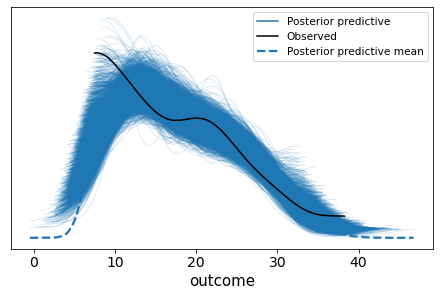

In [54]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc_all, model=model_2), var_names = ["outcome"])

In [55]:
trace_summary = az.summary(trace)
trace_summary = trace_summary.rename(columns={'mean': 'old_mean'})
trace_summary["mean"] = np.inf


for variable in list(trace_summary.index):
    #mean_variable = ppc_all[variable].mean()
    mean_variable = trace.posterior[variable].mean(axis = 0).mean().values
    trace_summary.loc[trace_summary.index == variable, "mean"] = mean_variable
	
	
y_true = data[target].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX]
y_pred = ppc_all["outcome"].mean(axis = 0) * 100_000

print(f"RMSE: {np.sqrt(np.mean((y_true - y_pred)**2))}")
print(f"MAPE: {np.mean(np.abs((y_true - y_pred) / y_true))}")
print(f"NRMSE: {nrmse(y_true, y_pred)}")

RMSE: 178675.05133813535
MAPE: 0.06829005740918648
NRMSE: 0.05798787764206024


### Residuals

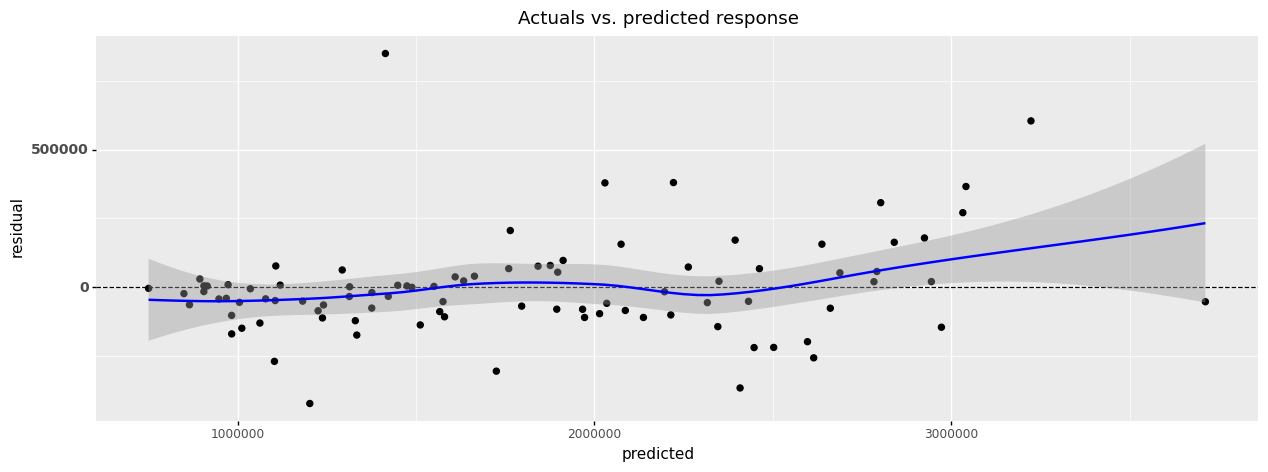

In [57]:
plot = plot_residuals(pd.DataFrame({"actual": y_true, "predicted": y_pred}), figure_size = (15, 5))
print(plot)

### Decomposition

In [58]:
adstock_params = trace_summary[trace_summary.index.str.contains("adstock")][["mean", "sd"]].reset_index().rename(columns = {'index': 'name'}).assign(name = lambda x: x["name"].str.replace("_adstock", ""))
saturation_params = pd.merge(
    trace_summary[trace_summary.index.str.contains("gamma")][["mean"]].reset_index().rename(columns = {'mean': 'gamma'}).assign(name = lambda x: x["index"].str.replace("_gamma", "")), 
    trace_summary[trace_summary.index.str.contains("alpha")][["mean"]].reset_index().rename(columns = {'mean': 'alpha'}).assign(name = lambda x: x["index"].str.replace("_alpha", "")), on = "name" )
control_coefficients = trace_summary[trace_summary.index.str.contains("_control_coef")][["mean", "sd"]].reset_index().assign(name = lambda x: x["index"].str.replace("_control_coef", ""))
delay_coefficients = trace_summary[trace_summary.index.str.contains("_media_coef")][["mean", "sd"]].reset_index().assign(name = lambda x: x["index"].str.replace("_media_coef", ""))

In [59]:
data_transformed_decomposed = data_transformed.copy()
intercept = trace_summary[trace_summary.index == "intercept"]["mean"].iloc[0]
data_transformed_decomposed["intercept"] = intercept
print(f"Intercept: {intercept}")

for delay_channel in delay_channels:
    print(delay_channel)
    
    adstock = adstock_params[adstock_params.name == delay_channel]
    adstock_theta = adstock["mean"].iloc[0]
    
    print(f"\tadstock {adstock_theta} transformation")
    
    data_transformed_decomposed[delay_channel] = adstock_geometric(data_transformed_decomposed[delay_channel].values, theta = adstock_theta)
    
    saturation = saturation_params[saturation_params.name == delay_channel]
    
    saturation_alpha = saturation["alpha"].iloc[0]
    saturation_gamma = saturation["gamma"].iloc[0]
    
    print(f"\tsaturation alpha {saturation_alpha}, gamma {saturation_gamma} transformation")
    
    #use the unbound version of saturation
    data_transformed_decomposed[delay_channel] = saturation_hill_pymc3(data_transformed_decomposed[delay_channel].values, alpha = saturation_alpha, gamma = saturation_gamma)
    
    coefs = delay_coefficients[delay_coefficients.name == delay_channel]
    coef = coefs["mean"].iloc[0]
    
    data_transformed_decomposed[delay_channel] = data_transformed_decomposed[delay_channel] * coef
    print(f"\tcoefficient: {coef}")
    
#apply coefficients

for variable in control_variables:
    coefs = control_coefficients[control_coefficients.name == variable]
    coef = coefs["mean"].iloc[0]
    print(f"Control Coefficient: {variable}: {coef}")
    data_transformed_decomposed[variable] = data_transformed_decomposed[variable] * coef
    


Intercept: 6.117475632287935
tv_S
	adstock 0.2987702066340169 transformation
	saturation alpha 2.67511199631532, gamma 0.28372236732049133 transformation
	coefficient: 4.169608899160331
ooh_S
	adstock 0.5011081759757688 transformation
	saturation alpha 3.1187142918189092, gamma 0.5620428606973983 transformation
	coefficient: 1.5691763422365084
print_S
	adstock 0.37317194928093345 transformation
	saturation alpha 2.9866128923034085, gamma 0.5031002234648588 transformation
	coefficient: 2.062761702264111
facebook_I
	adstock 0.5060739913131923 transformation
	saturation alpha 2.9401757580922254, gamma 0.5322345034073863 transformation
	coefficient: 0.8603025540318582
search_clicks_P
	adstock 0.4114466795610565 transformation
	saturation alpha 3.3327510742825823, gamma 0.6138799080769279 transformation
	coefficient: 1.3284007363467332
newsletter
	adstock 0.36934472934874735 transformation
	saturation alpha 3.937460429755027, gamma 0.6565151787120507 transformation
	coefficient: 2.371043187

RMSE: 185432.77416161433
MAPE: 0.06759556730441772
NRMSE: 0.05798787764206024


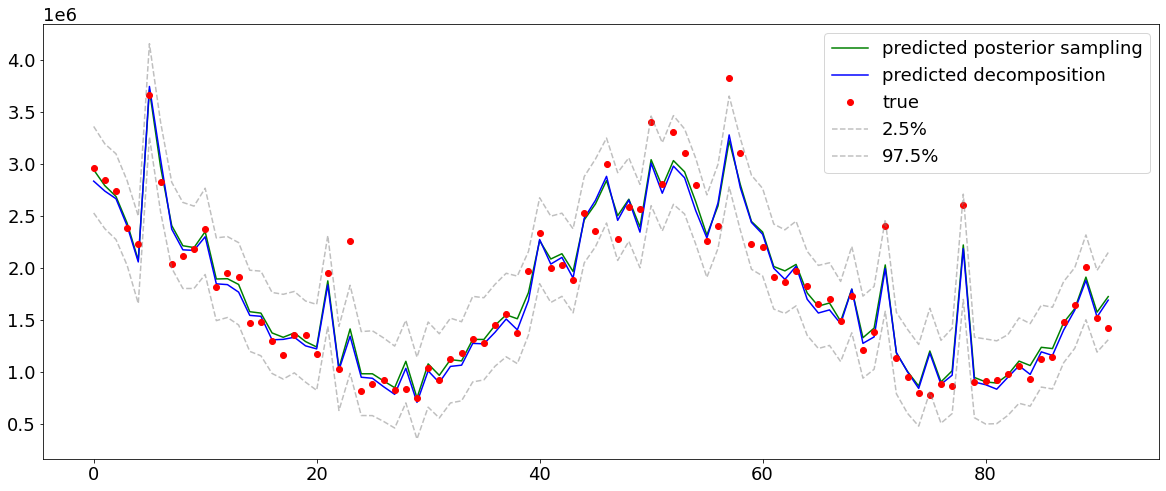

In [61]:
data_transformed_decomposed["prediction"] = data_transformed_decomposed[delay_channels + control_variables + ["intercept"]].sum(axis = 1)
y_pred_decomposed = data_transformed_decomposed["prediction"].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX] * 100_000


print(f"RMSE: {np.sqrt(np.mean((y_true - y_pred_decomposed)**2))}")
print(f"MAPE: {np.mean(np.abs((y_true - y_pred_decomposed) / y_true))}")
print(f"NRMSE: {nrmse(y_true, y_pred)}")
qs = mquantiles(100_000 * (ppc_all["outcome"]), [0.025, 0.975], axis=0)
qs_decomposed = mquantiles(100_000 * (ppc_all["outcome"]), [0.025, 0.975], axis=0)
fig, ax = plt.subplots(figsize = (20, 8))
_ = ax.plot((ppc_all["outcome"].mean(axis = 0) * 100_000), color = "green", label = "predicted posterior sampling")
_ = ax.plot(y_pred_decomposed, color = "blue", label = "predicted decomposition")
_ = ax.plot(data[target].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX], 'ro', label = "true")
_ = ax.plot(qs[0], '--', color = "grey", label = "2.5%", alpha = 0.5)
_ = ax.plot(qs[1], '--', color = "grey", label = "97.5%", alpha = 0.5)
_ = ax.legend()



In [62]:
media_spend_exposure_df

,spend,exposure,V_max,K_m
0,facebook_S,facebook_I,1288297663.56310,3164938.37724
1,search_S,search_clicks_P,751750.93339,600985.07717


In [63]:
spend_df = pd.DataFrame()
for media_channel in media_channels:
    temp_series = data[media_channel].iloc[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX].values
    #exposure to spend should
    if len(media_spend_exposure_df[media_spend_exposure_df.exposure == media_channel]) > 0:
        
        vmax = media_spend_exposure_df[media_spend_exposure_df.exposure == media_channel]["V_max"].iloc[0]
        km = media_spend_exposure_df[media_spend_exposure_df.exposure == media_channel]["K_m"].iloc[0]
        spends = exposure_to_spend_menten_func(temp_series, V_max = vmax, K_m = km)
        spends_total = spends.sum()
    else:
        spends_total = temp_series.sum()
        
    spend_df = pd.concat([spend_df, pd.DataFrame({'media': [media_channel], 'total_spend': [spends_total]})]).reset_index(drop=True)

spend_df["spend_share"] = spend_df["total_spend"] / spend_df["total_spend"].sum()
spend_df

,media,total_spend,spend_share
0,tv_S,10247935.10000,0.31081
1,ooh_S,10240536.00000,0.31059
2,print_S,2793216.00000,0.08472
3,facebook_I,6031315.27955,0.18293
4,search_clicks_P,3658251.58463,0.11095


In [64]:
response_df = pd.DataFrame()
for media_channel in media_channels:
    response = data_transformed_decomposed[media_channel].iloc[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX].values
    response_total = response.sum()
    
    response_df = pd.concat([response_df, pd.DataFrame({'media': [media_channel], 'total_effect': [response_total]})]).reset_index(drop=True)
response_df["effect_share"] = response_df["total_effect"] / response_df["total_effect"].sum()

response_df

,media,total_effect,effect_share
0,tv_S,63.77157,0.38274
1,ooh_S,18.68400,0.11214
2,print_S,24.98731,0.14997
3,facebook_I,17.50423,0.10506
4,search_clicks_P,41.67147,0.25010


In [65]:
spend_response_share_df = pd.concat([spend_df, response_df.drop(columns=["media"])], axis = 1)
spend_response_share_df

,media,total_spend,spend_share,total_effect,effect_share
0,tv_S,10247935.10000,0.31081,63.77157,0.38274
1,ooh_S,10240536.00000,0.31059,18.68400,0.11214
2,print_S,2793216.00000,0.08472,24.98731,0.14997
3,facebook_I,6031315.27955,0.18293,17.50423,0.10506
4,search_clicks_P,3658251.58463,0.11095,41.67147,0.25010


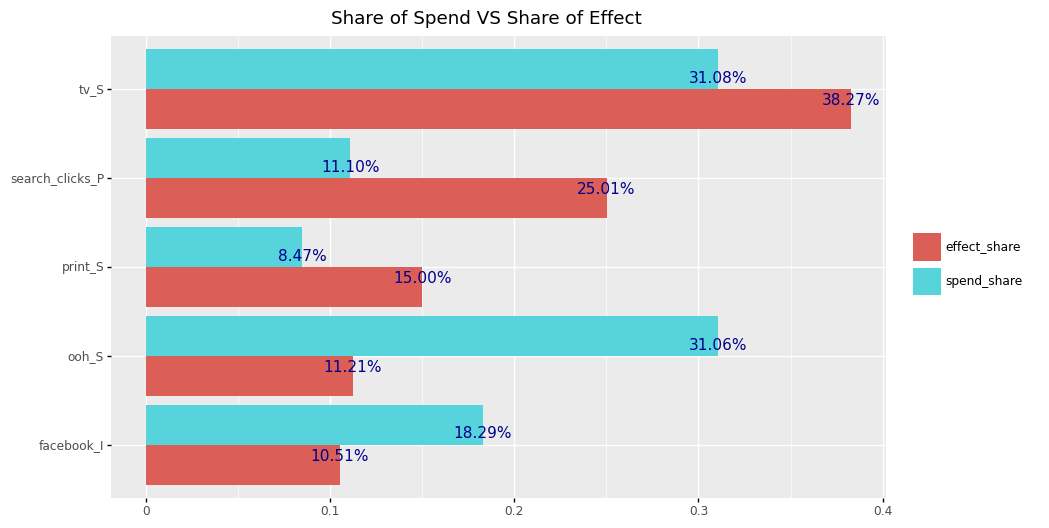

<ggplot: (-9223371869844969648)>

In [66]:
plot_spend_vs_effect_share(spend_response_share_df, figure_size = (10, 6))

## Dependent Variable Transfrormation : 0-1

Delay Channels: Adding tv_S
Delay Channels: Adding ooh_S
Delay Channels: Adding print_S
Delay Channels: Adding facebook_I
Delay Channels: Adding search_clicks_P
Delay Channels: Adding newsletter
Control Variables: Adding trend
Control Variables: Adding season
Control Variables: Adding holiday
Control Variables: Adding competitor_sales_B
Control Variables: Adding events


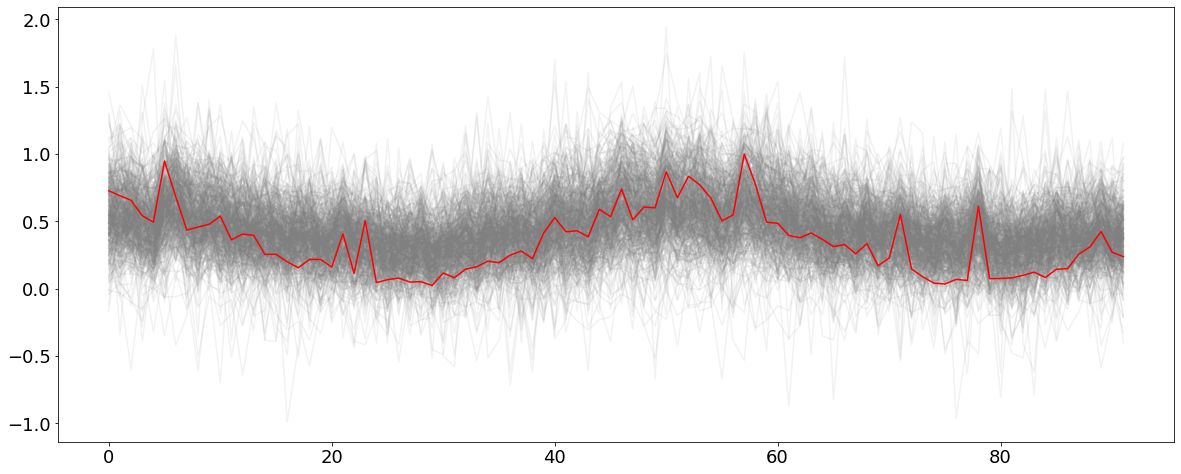

In [67]:
transform_variables = ["trend",	"season", "holiday", "competitor_sales_B",	"events", "tv_S", "ooh_S", "print_S", "facebook_I", "search_clicks_P", "newsletter"]

delay_channels = ["tv_S", "ooh_S", "print_S", "facebook_I", "search_clicks_P", "newsletter"]

media_channels = ["tv_S", "ooh_S", "print_S", "facebook_I", "search_clicks_P"]

control_variables = ["trend", "season", "holiday", "competitor_sales_B", "events"]


data_transformed = data.copy()

numerical_encoder_dict = {}

for feature in transform_variables:
    scaler = MinMaxScaler()
    original = data[feature].values.reshape(-1, 1)
    transformed = scaler.fit_transform(original)
    data_transformed[feature] = transformed
    numerical_encoder_dict[feature] = scaler

#dependent_transformation = PowerTransformer(method = "box-cox")
dependent_transformation = MinMaxScaler()
original = data[target].values.reshape(-1, 1)
transformed = dependent_transformation.fit_transform(original)
data_transformed[target] = transformed

#############


    
response_mean = []
with pm.Model() as model_3:
    for channel_name in delay_channels:
        print(f"Delay Channels: Adding {channel_name}")
        
        x = data_transformed[channel_name].values
        
        
        
        adstock_param = pm.Beta(f"{channel_name}_adstock", 3, 3)
        saturation_gamma = pm.Beta(f"{channel_name}_gamma", 2, 2)
        saturation_alpha = pm.Gamma(f"{channel_name}_alpha", 3, 1)
        
        x_new = adstock_geometric_theano_pymc3(x, adstock_param)
        x_new_sliced = x_new[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX]
        saturation_tensor = saturation_hill_pymc3(x_new_sliced, saturation_alpha, saturation_gamma)
        
        channel_b = pm.HalfNormal(f"{channel_name}_media_coef", sd = 0.1)
        response_mean.append(saturation_tensor * channel_b)
        
    for control_var in control_variables:
        print(f"Control Variables: Adding {control_var}")
        
        x = data_transformed[control_var].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX]
        
        control_beta = pm.Normal(f"{control_var}_control_coef", 0.1, sd = 0.1)
        control_x = control_beta * x
        response_mean.append(control_x)
        
    #intercept = pm.Normal("intercept", mu = 0.10, sd = 0.1)
    intercept = pm.HalfNormal("intercept", 0.1)
        
    sigma = pm.HalfNormal("sigma", 0.15)
    
    likelihood = pm.Normal("outcome", mu = intercept + sum(response_mean), sd = sigma, observed = data_transformed[target].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX])
        
######################

with model_3:
    prior_pred = pm.sample_prior_predictive()
    
fig, ax = plt.subplots(figsize = (20, 8))
_ = ax.plot(prior_pred["outcome"].T, color = "0.5", alpha = 0.1)
_ = ax.plot(data_transformed[target].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX], color = "red")

adstock priors: 6
alpha priors: 6
gamma priors: 6
media coef priors: 6
control coef priors: 6
sigma prior: 1


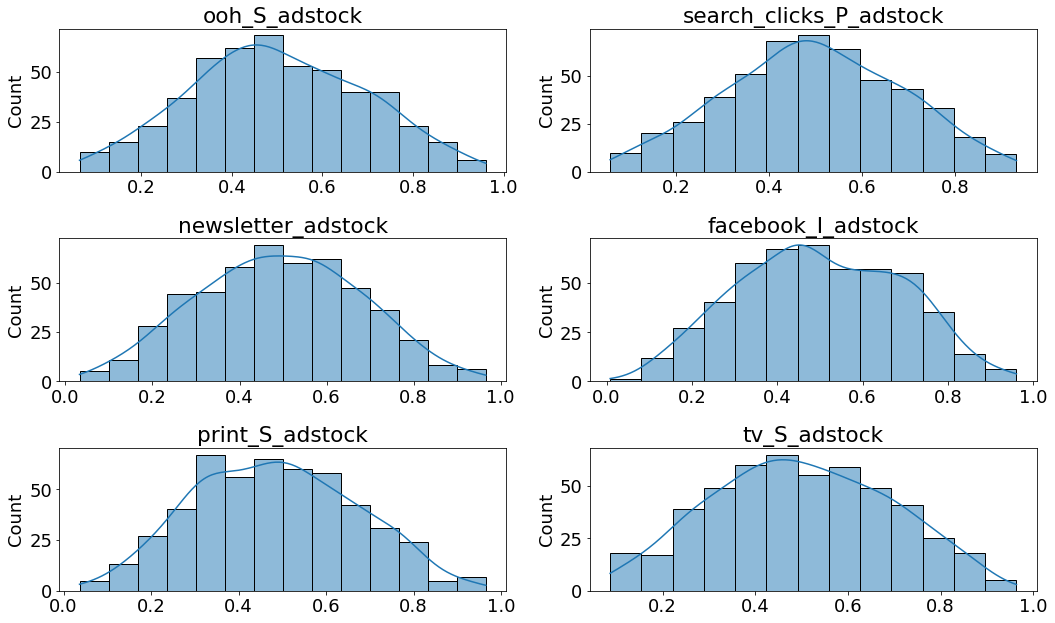

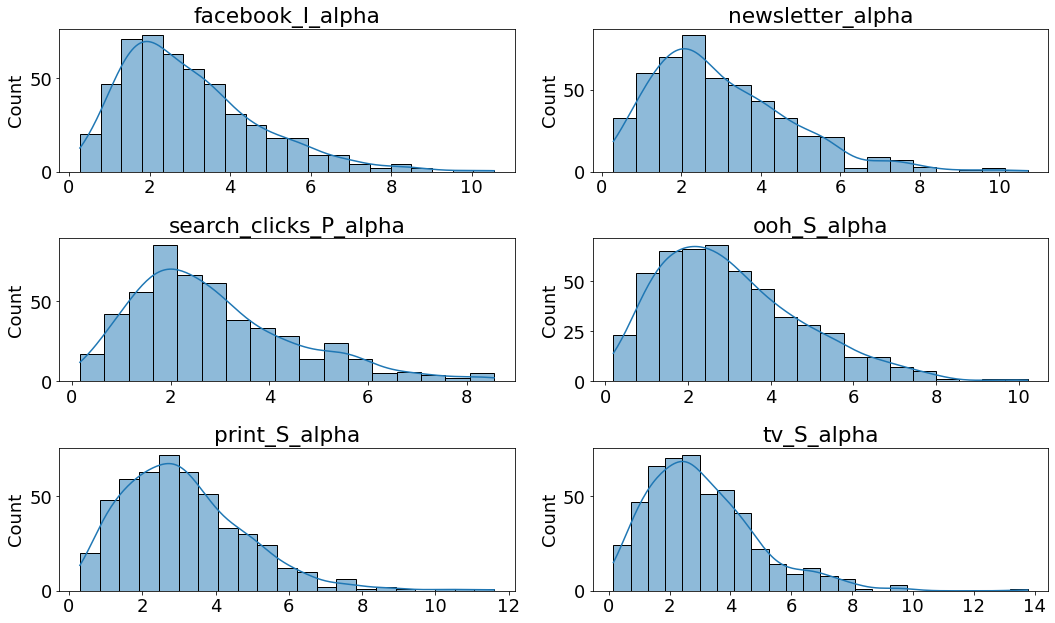

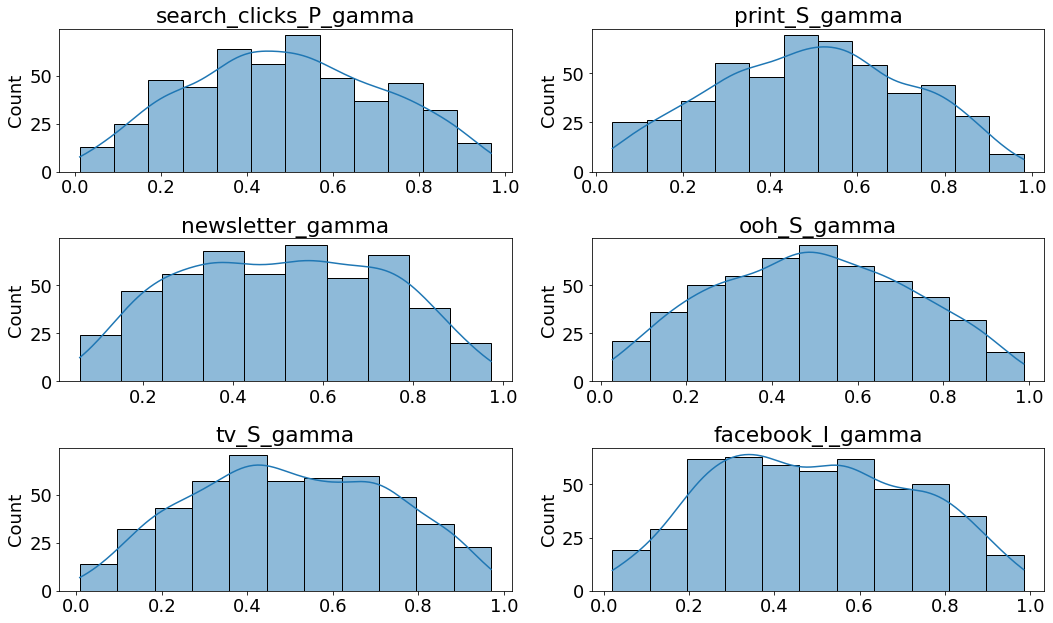

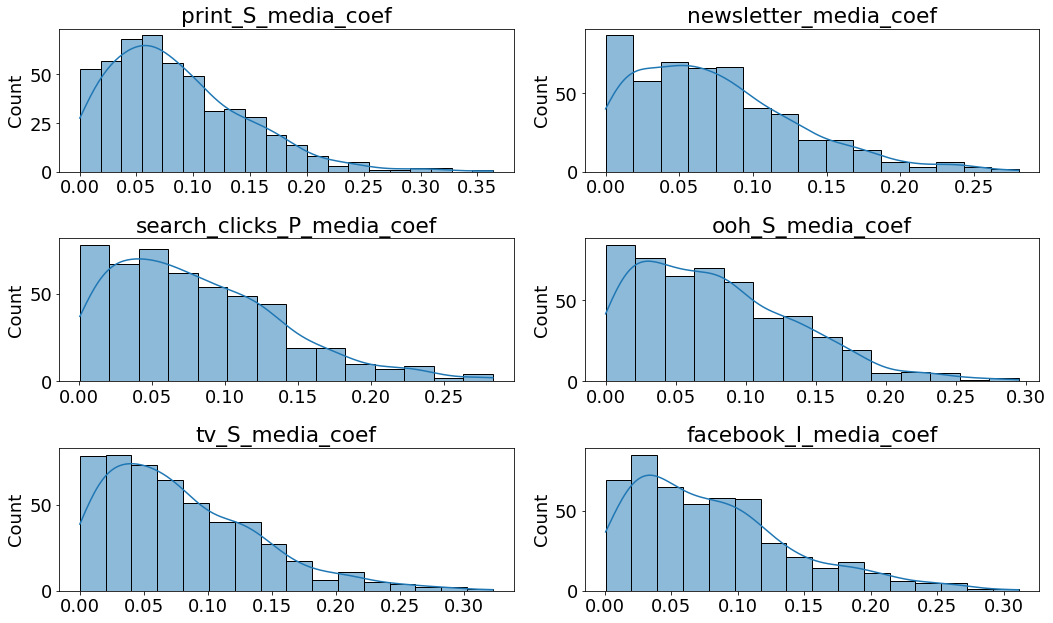

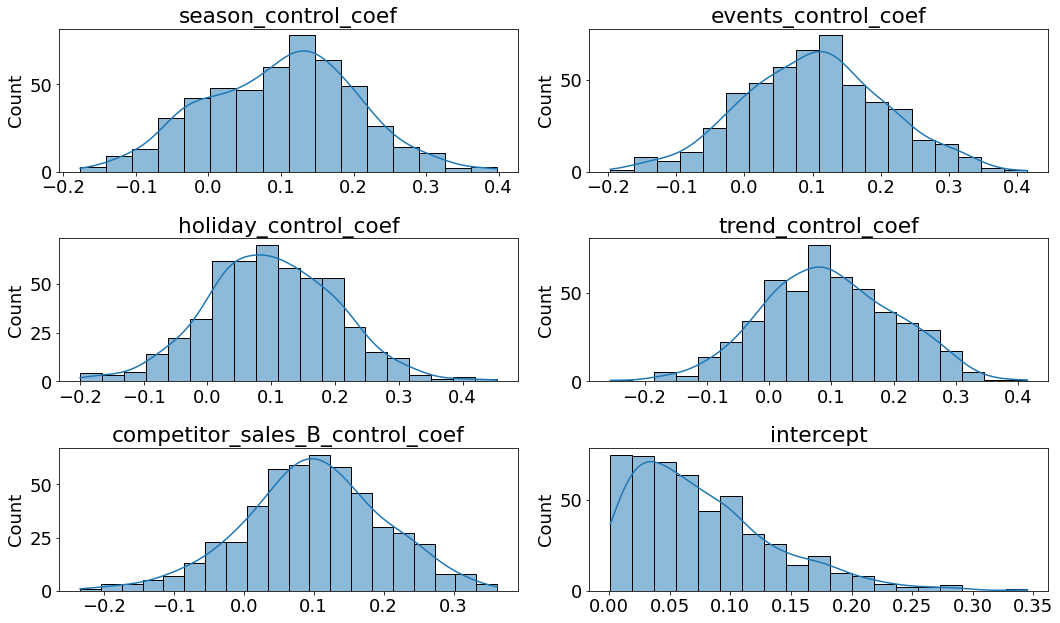

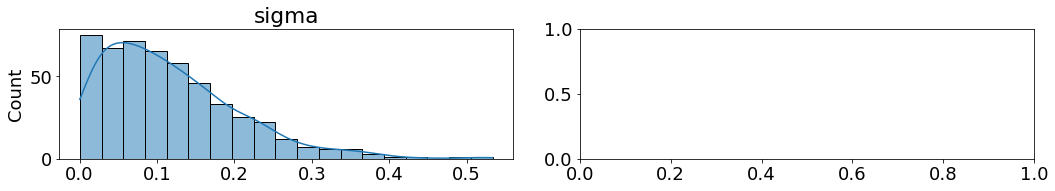

In [68]:
prior_names = [prior_name for prior_name in list(prior_pred.keys()) if (prior_name.endswith("logodds__") == False) & (prior_name.endswith("_log__") == False)]

adstock_priors = [p for p in prior_names if p.endswith("adstock")]
plot_priors(adstock_priors, prior_pred)
print(f"adstock priors: {len(adstock_priors)}")

alpha_priors = [p for p in prior_names if p.endswith("alpha")]
plot_priors(alpha_priors, prior_pred)
print(f"alpha priors: {len(alpha_priors)}")

gamma_priors = [p for p in prior_names if p.endswith("gamma")]
plot_priors(gamma_priors, prior_pred)
print(f"gamma priors: {len(gamma_priors)}")


media_coef_priors = [p for p in prior_names if p.endswith("media_coef")]
plot_priors(media_coef_priors, prior_pred)
print(f"media coef priors: {len(media_coef_priors)}")

control_coef_priors = [p for p in prior_names if p.endswith("control_coef")] + ["intercept"]
plot_priors(control_coef_priors, prior_pred)
print(f"control coef priors: {len(control_coef_priors)}")

plot_priors(["sigma"], prior_pred)
print(f"sigma prior: 1")

### Sample

In [69]:
with model_3:
    trace = pm.sample(1000, tune=1000, step=None, target_accept = 0.95, return_inferencedata=True)
    trace_summary = az.summary(trace)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, intercept, events_control_coef, competitor_sales_B_control_coef, holiday_control_coef, season_control_coef, trend_control_coef, newsletter_media_coef, newsletter_alpha, newsletter_gamma, newsletter_adstock, search_clicks_P_media_coef, search_clicks_P_alpha, search_clicks_P_gamma, search_clicks_P_adstock, facebook_I_media_coef, facebook_I_alpha, facebook_I_gamma, facebook_I_adstock, print_S_media_coef, print_S_alpha, print_S_gamma, print_S_adstock, ooh_S_media_coef, ooh_S_alpha, ooh_S_gamma, ooh_S_adstock, tv_S_media_coef, tv_S_alpha, tv_S_gamma, tv_S_adstock]
INFO:pymc3:NUTS: [sigma, intercept, events_control_coef, competitor_sales_B_control_coef, holiday_control_coef, season_control_coef, trend_control_co

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5179 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5179 seconds.


<AxesSubplot:xlabel='outcome'>

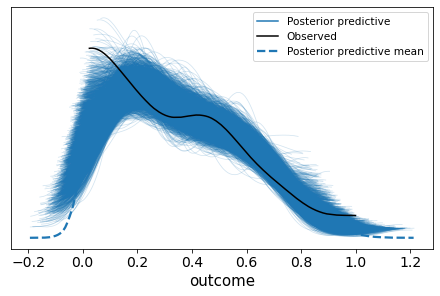

In [70]:
with model_3:
    ppc_all = pm.sample_posterior_predictive(
        trace, var_names=["outcome"] + list(trace_summary.index), random_seed=42
    )
    
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc_all, model=model_3), var_names = ["outcome"])

In [71]:
trace_summary = az.summary(trace)
trace_summary = trace_summary.rename(columns={'mean': 'old_mean'})
trace_summary["mean"] = np.inf


for variable in list(trace_summary.index):
    mean_variable = ppc_all[variable].mean()
    trace_summary.loc[trace_summary.index == variable, "mean"] = mean_variable
	
	
y_true = data[target].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX]
y_pred = dependent_transformation.inverse_transform(ppc_all["outcome"].mean(axis = 0).reshape(-1, 1)).reshape(-1)

print(np.sqrt(np.mean((y_true - y_pred)**2)))
print(np.mean(np.abs((y_true - y_pred) / y_true)))
print(nrmse(y_true, y_pred))


adstock_params = trace_summary[trace_summary.index.str.contains("adstock")][["mean", "sd"]].reset_index().rename(columns = {'index': 'name'}).assign(name = lambda x: x["name"].str.replace("_adstock", ""))
saturation_params = pd.merge(
    trace_summary[trace_summary.index.str.contains("gamma")][["mean"]].reset_index().rename(columns = {'mean': 'gamma'}).assign(name = lambda x: x["index"].str.replace("_gamma", "")), 
    trace_summary[trace_summary.index.str.contains("alpha")][["mean"]].reset_index().rename(columns = {'mean': 'alpha'}).assign(name = lambda x: x["index"].str.replace("_alpha", "")), on = "name" )
control_coefficients = trace_summary[trace_summary.index.str.contains("_control_coef")][["mean", "sd"]].reset_index().assign(name = lambda x: x["index"].str.replace("_control_coef", ""))
delay_coefficients = trace_summary[trace_summary.index.str.contains("_media_coef")][["mean", "sd"]].reset_index().assign(name = lambda x: x["index"].str.replace("_media_coef", ""))


175107.61175147534
0.06665322233519279
0.056830087291939155


### Decomposition

In [72]:
data_transformed_decomposed = data_transformed.copy()
intercept = trace_summary[trace_summary.index == "intercept"]["mean"].iloc[0]
data_transformed_decomposed["intercept"] = intercept
print(f"Intercept: {intercept}")

for delay_channel in delay_channels:
    print(delay_channel)
    
    adstock = adstock_params[adstock_params.name == delay_channel]
    adstock_theta = adstock["mean"].iloc[0]
    
    print(f"\tadstock {adstock_theta} transformation")
    
    data_transformed_decomposed[delay_channel] = adstock_geometric(data_transformed_decomposed[delay_channel].values, theta = adstock_theta)
    
    saturation = saturation_params[saturation_params.name == delay_channel]
    
    saturation_alpha = saturation["alpha"].iloc[0]
    saturation_gamma = saturation["gamma"].iloc[0]
    
    print(f"\tsaturation alpha {saturation_alpha}, gamma {saturation_gamma} transformation")
    
    #use the unbound version of saturation
    data_transformed_decomposed[delay_channel] = saturation_hill_pymc3(data_transformed_decomposed[delay_channel].values, alpha = saturation_alpha, gamma = saturation_gamma)
    
    coefs = delay_coefficients[delay_coefficients.name == delay_channel]
    coef = coefs["mean"].iloc[0]
    
    data_transformed_decomposed[delay_channel] = data_transformed_decomposed[delay_channel] * coef
    print(f"\tcoefficient: {coef}")
    
#apply coefficients

for variable in control_variables:
    coefs = control_coefficients[control_coefficients.name == variable]
    coef = coefs["mean"].iloc[0]
    print(f"Control Coefficient: {variable}: {coef}")
    data_transformed_decomposed[variable] = data_transformed_decomposed[variable] * coef
    
data_transformed_decomposed["prediction"] = data_transformed_decomposed[delay_channels + control_variables + ["intercept"]].sum(axis = 1)
y_pred_decomposed = dependent_transformation.inverse_transform(data_transformed_decomposed["prediction"].values.reshape(-1,1))[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX].reshape(-1)

Intercept: 0.012162514494269888
tv_S
	adstock 0.2911973243986447 transformation
	saturation alpha 2.774168986582854, gamma 0.27947197336755425 transformation
	coefficient: 0.1299902839816507
ooh_S
	adstock 0.48565820178208396 transformation
	saturation alpha 3.1261630770589517, gamma 0.5733720964419335 transformation
	coefficient: 0.045011560759012324
print_S
	adstock 0.3538345049789241 transformation
	saturation alpha 3.087596565372988, gamma 0.5027237111461783 transformation
	coefficient: 0.06512393197839109
facebook_I
	adstock 0.4852689386487537 transformation
	saturation alpha 2.9505830744448684, gamma 0.5420913414271875 transformation
	coefficient: 0.020399217746052536
search_clicks_P
	adstock 0.39641985378287925 transformation
	saturation alpha 3.501752569074848, gamma 0.628109812595281 transformation
	coefficient: 0.03833852640988764
newsletter
	adstock 0.35329621581148674 transformation
	saturation alpha 4.407067124589413, gamma 0.6863762891021988 transformation
	coefficient: 0

In [93]:
y_true = data[target].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX]
y_pred = dependent_transformation.inverse_transform(ppc_all["outcome"].mean(axis = 0).reshape(-1, 1)).reshape(-1)


print(f"RMSE: {np.sqrt(np.mean((y_true - y_pred)**2))}")
print(f"MAPE: {np.mean(np.abs((y_true - y_pred) / y_true))}")
print(f"NRMSE: {nrmse(y_true, y_pred)}")

175243.66714704357
0.06666040401276786


RMSE: 179380.561753302
MAPE: 0.06559278489713702
NRMSE: 0.058216846663328124


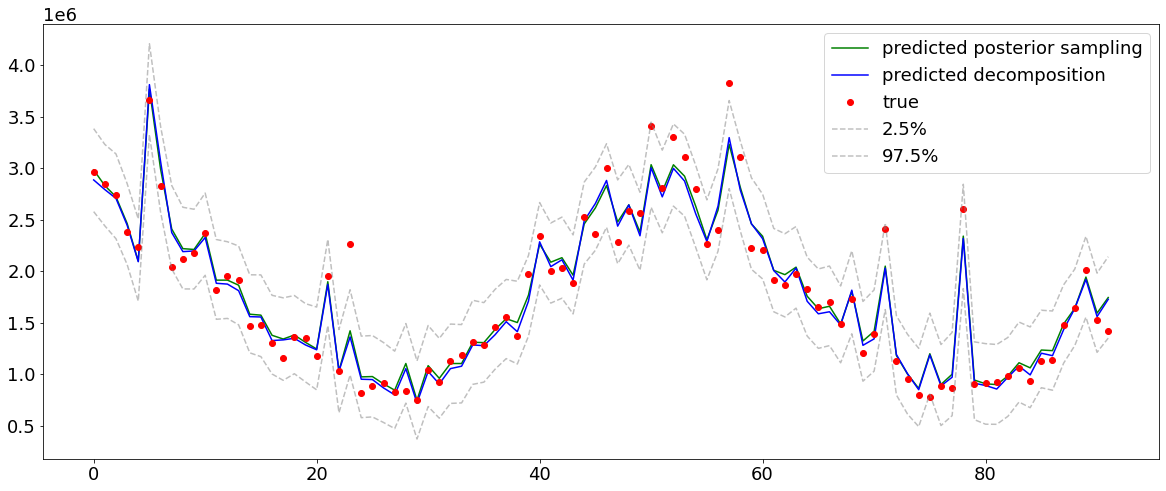

In [73]:
print(f"RMSE: {np.sqrt(np.mean((y_true - y_pred_decomposed)**2))}")
print(f"MAPE: {np.mean(np.abs((y_true - y_pred_decomposed) / y_true))}")
print(f"NRMSE: {nrmse(y_true, y_pred_decomposed)}")

qs = mquantiles(dependent_transformation.inverse_transform(ppc_all["outcome"]), [0.025, 0.975], axis=0)
qs_decomposed = mquantiles(dependent_transformation.inverse_transform(ppc_all["outcome"]), [0.025, 0.975], axis=0)
fig, ax = plt.subplots(figsize = (20, 8))
_ = ax.plot(dependent_transformation.inverse_transform(ppc_all["outcome"].mean(axis = 0).reshape(-1, 1)), color = "green", label = "predicted posterior sampling")
_ = ax.plot(y_pred_decomposed, color = "blue", label = "predicted decomposition")
_ = ax.plot(data[target].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX], 'ro', label = "true")
_ = ax.plot(qs[0], '--', color = "grey", label = "2.5%", alpha = 0.5)
_ = ax.plot(qs[1], '--', color = "grey", label = "97.5%", alpha = 0.5)
_ = ax.legend()

In [74]:
spend_df = pd.DataFrame()
for media_channel in media_channels:
    temp_series = data[media_channel].iloc[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX].values
    #exposure to spend should
    if len(media_spend_exposure_df[media_spend_exposure_df.exposure == media_channel]) > 0:
        
        vmax = media_spend_exposure_df[media_spend_exposure_df.exposure == media_channel]["V_max"].iloc[0]
        km = media_spend_exposure_df[media_spend_exposure_df.exposure == media_channel]["K_m"].iloc[0]
        spends = exposure_to_spend_menten_func(temp_series, V_max = vmax, K_m = km)
        spends_total = spends.sum()
    else:
        spends_total = temp_series.sum()
        
    spend_df = pd.concat([spend_df, pd.DataFrame({'media': [media_channel], 'total_spend': [spends_total]})]).reset_index(drop=True)

spend_df["spend_share"] = spend_df["total_spend"] / spend_df["total_spend"].sum()
spend_df


,media,total_spend,spend_share
0,tv_S,10247935.10000,0.31081
1,ooh_S,10240536.00000,0.31059
2,print_S,2793216.00000,0.08472
3,facebook_I,6031315.27955,0.18293
4,search_clicks_P,3658251.58463,0.11095


In [75]:
response_df = pd.DataFrame()
for media_channel in media_channels:
    response = data_transformed_decomposed[media_channel].iloc[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX].values
    response_total = response.sum()
    
    response_df = pd.concat([response_df, pd.DataFrame({'media': [media_channel], 'total_effect': [response_total]})]).reset_index(drop=True)
response_df["effect_share"] = response_df["total_effect"] / response_df["total_effect"].sum()

response_df


,media,total_effect,effect_share
0,tv_S,1.98175,0.41954
1,ooh_S,0.49752,0.10533
2,print_S,0.75054,0.15889
3,facebook_I,0.38331,0.08115
4,search_clicks_P,1.11053,0.23510


In [76]:
spend_response_share_df = pd.concat([spend_df, response_df.drop(columns=["media"])], axis = 1)
spend_response_share_df

,media,total_spend,spend_share,total_effect,effect_share
0,tv_S,10247935.10000,0.31081,1.98175,0.41954
1,ooh_S,10240536.00000,0.31059,0.49752,0.10533
2,print_S,2793216.00000,0.08472,0.75054,0.15889
3,facebook_I,6031315.27955,0.18293,0.38331,0.08115
4,search_clicks_P,3658251.58463,0.11095,1.11053,0.23510


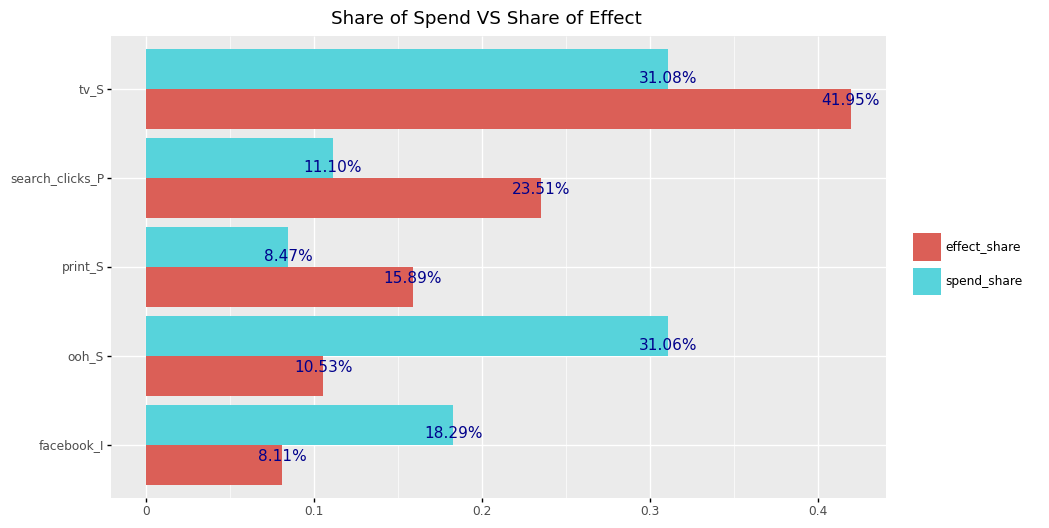

<ggplot: (-9223371869864680460)>

In [77]:
plot_spend_vs_effect_share(spend_response_share_df, figure_size = (10, 6))

## Dependent Variable Transformation: 0-1, more restrictive priors for media channels as suggested by Robyn

Delay Channels: Adding tv_S
Delay Channels: Adding ooh_S
Delay Channels: Adding print_S
Delay Channels: Adding facebook_I
Delay Channels: Adding search_clicks_P
Delay Channels: Adding newsletter
Control Variables: Adding trend
Control Variables: Adding season
Control Variables: Adding holiday
Control Variables: Adding competitor_sales_B
Control Variables: Adding events


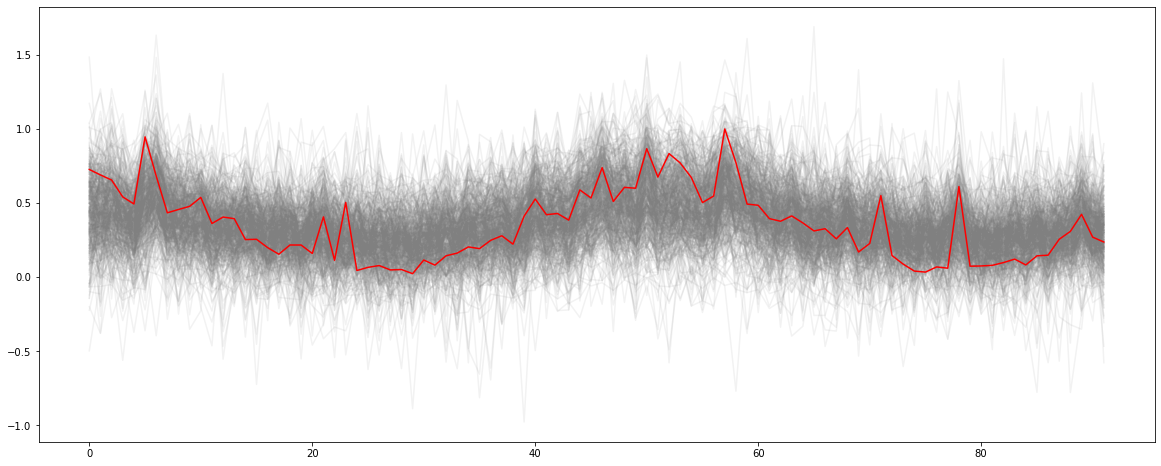

In [113]:
transform_variables = ["trend",	"season", "holiday", "competitor_sales_B",	"events", "tv_S", "ooh_S", "print_S", "facebook_I", "search_clicks_P", "newsletter"]

delay_channels = ["tv_S", "ooh_S", "print_S", "facebook_I", "search_clicks_P", "newsletter"]

media_channels = ["tv_S", "ooh_S", "print_S", "facebook_I", "search_clicks_P"]

control_variables = ["trend", "season", "holiday", "competitor_sales_B", "events"]


data_transformed = data.copy()

numerical_encoder_dict = {}

for feature in transform_variables:
    scaler = MinMaxScaler()
    original = data[feature].values.reshape(-1, 1)
    transformed = scaler.fit_transform(original)
    data_transformed[feature] = transformed
    numerical_encoder_dict[feature] = scaler

#dependent_transformation = PowerTransformer(method = "box-cox")
dependent_transformation = MinMaxScaler()
original = data[target].values.reshape(-1, 1)
transformed = dependent_transformation.fit_transform(original)
data_transformed[target] = transformed

#############


    
response_mean = []
with pm.Model() as model_4:
    for channel_name in delay_channels:
        print(f"Delay Channels: Adding {channel_name}")
        
        x = data_transformed[channel_name].values
        
        
        
        #adstock_param = pm.Beta(f"{channel_name}_adstock", 3, 3)
        if channel_name == "facebook_I":
            adstock_param = pm.Bound(pm.Beta, lower=0.0, upper=0.3)(f"{channel_name}_adstock", 3, 3)
        elif channel_name == "print_S":
            adstock_param = pm.Bound(pm.Beta, lower=0.1, upper=0.4)(f"{channel_name}_adstock", 3, 3)
        elif channel_name == "tv_S":
            adstock_param = pm.Bound(pm.Beta, lower=0.3, upper=0.8)(f"{channel_name}_adstock", 3, 3)
        elif channel_name == "search_clicks_P":
            adstock_param = pm.Bound(pm.Beta, lower=0.0, upper=0.3)(f"{channel_name}_adstock", 3, 3)
        elif channel_name == "ooh_S":
            adstock_param = pm.Bound(pm.Beta, lower=0.1, upper=0.4)(f"{channel_name}_adstock", 3, 3)
        elif channel_name == "newsletter":
            adstock_param = pm.Bound(pm.Beta, lower=0.1, upper=0.4)(f"{channel_name}_adstock", 3, 3)
        else:
            raise Exception(f"unknown channel: {channel_name}")
        
        #saturation_gamma = pm.Beta(f"{channel_name}_gamma", 2, 2)
        if channel_name == "facebook_I":
            saturation_gamma = pm.Bound(pm.Beta, lower=0.3, upper=1.0)(f"{channel_name}_gamma", 2, 2)
        elif channel_name == "print_S":
            saturation_gamma = pm.Bound(pm.Beta, lower=0.3, upper=1.0)(f"{channel_name}_gamma", 2, 2)
        elif channel_name == "tv_S":
            saturation_gamma = pm.Bound(pm.Beta, lower=0.3, upper=1.0)(f"{channel_name}_gamma", 2, 2)
        elif channel_name == "search_clicks_P":
            saturation_gamma = pm.Bound(pm.Beta, lower=0.3, upper=1.0)(f"{channel_name}_gamma", 2, 2)
        elif channel_name == "ooh_S":
            saturation_gamma = pm.Bound(pm.Beta, lower=0.3, upper=1.0)(f"{channel_name}_gamma", 2, 2)
        elif channel_name == "newsletter":
            saturation_gamma = pm.Bound(pm.Beta, lower=0.3, upper=1.0)(f"{channel_name}_gamma", 2, 2)
        else:
            raise Exception(f"unknown channel: {channel_name}")
        
        
        saturation_alpha = pm.Gamma(f"{channel_name}_alpha", 3, 1)
        
        x_new = adstock_geometric_theano_pymc3(x, adstock_param)
        x_new_sliced = x_new[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX]
        saturation_tensor = saturation_hill_pymc3(x_new_sliced, saturation_alpha, saturation_gamma)
        
        channel_b = pm.HalfNormal(f"{channel_name}_media_coef", sd = 0.1)
        response_mean.append(saturation_tensor * channel_b)
        
    for control_var in control_variables:
        print(f"Control Variables: Adding {control_var}")
        
        x = data_transformed[control_var].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX]
        
        control_beta = pm.Normal(f"{control_var}_control_coef", 0.1, sd = 0.1)
        control_x = control_beta * x
        response_mean.append(control_x)
        
    #intercept = pm.Normal("intercept", mu = 0.10, sd = 0.1)
    intercept = pm.HalfNormal("intercept", 0.1)
        
    sigma = pm.HalfNormal("sigma", 0.15)
    
    likelihood = pm.Normal("outcome", mu = intercept + sum(response_mean), sd = sigma, observed = data_transformed[target].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX])
        
######################

with model_4:
    prior_pred = pm.sample_prior_predictive()
    
fig, ax = plt.subplots(figsize = (20, 8))
_ = ax.plot(prior_pred["outcome"].T, color = "0.5", alpha = 0.1)
_ = ax.plot(data_transformed[target].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX], color = "red")

adstock priors: 6
alpha priors: 6
gamma priors: 6
media coef priors: 6
control coef priors: 6
sigma prior: 1


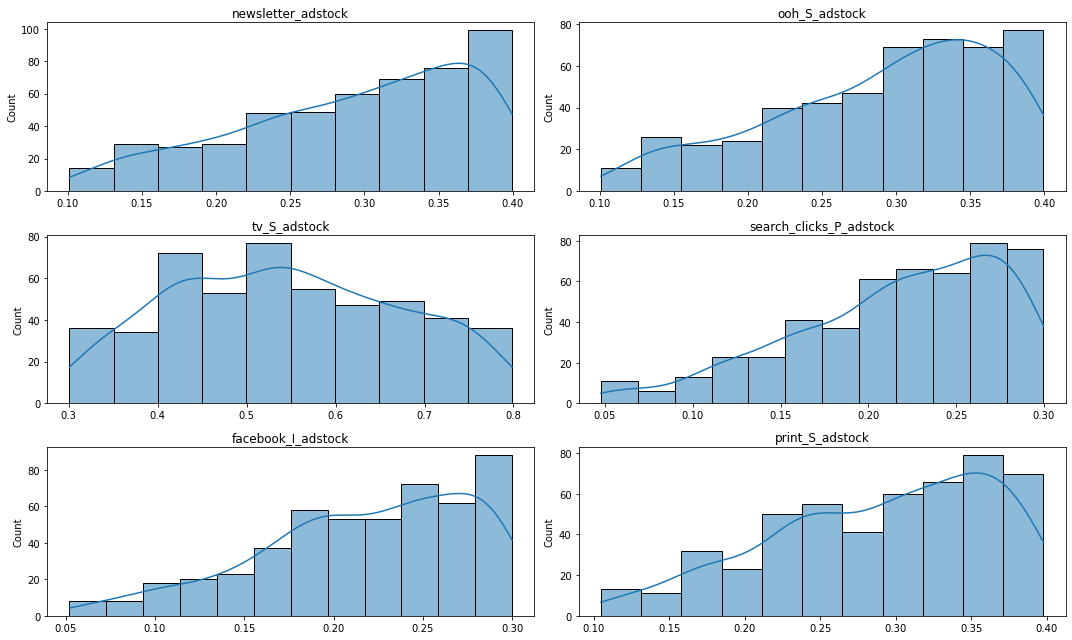

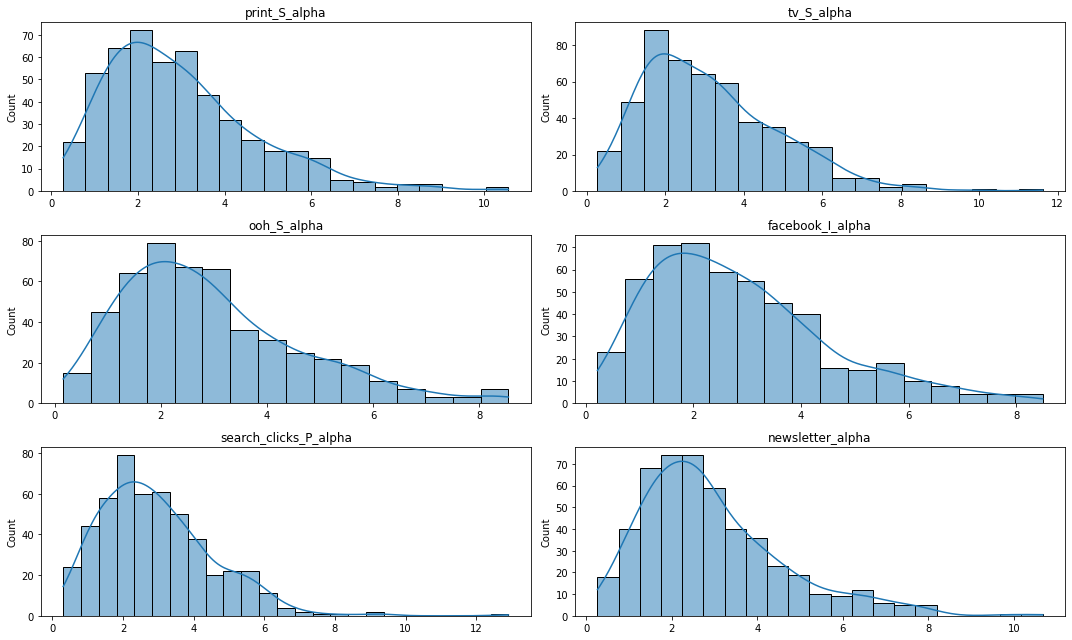

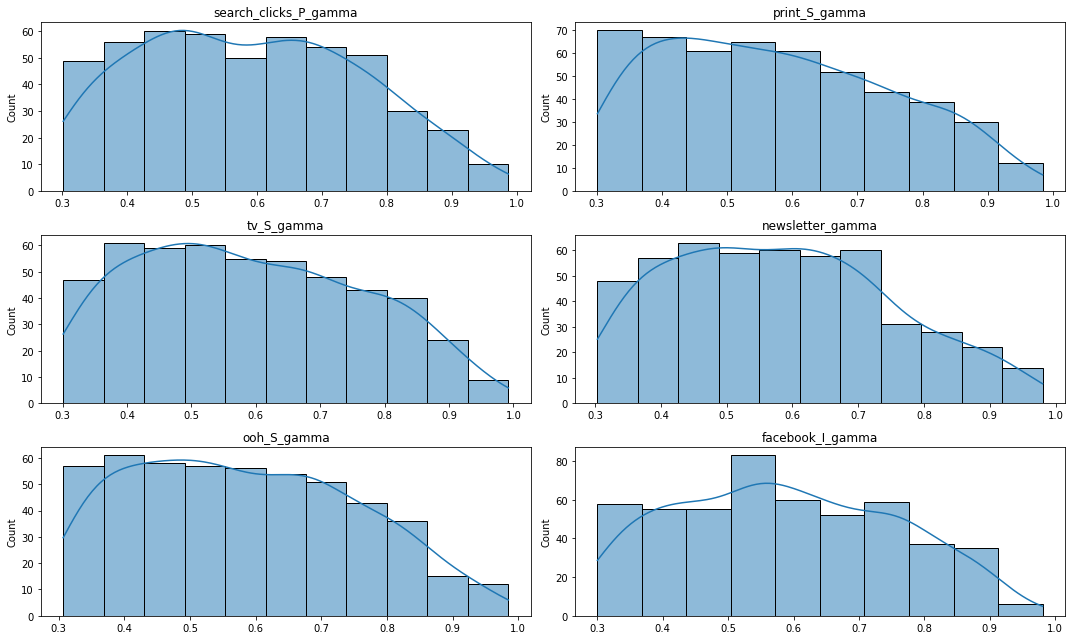

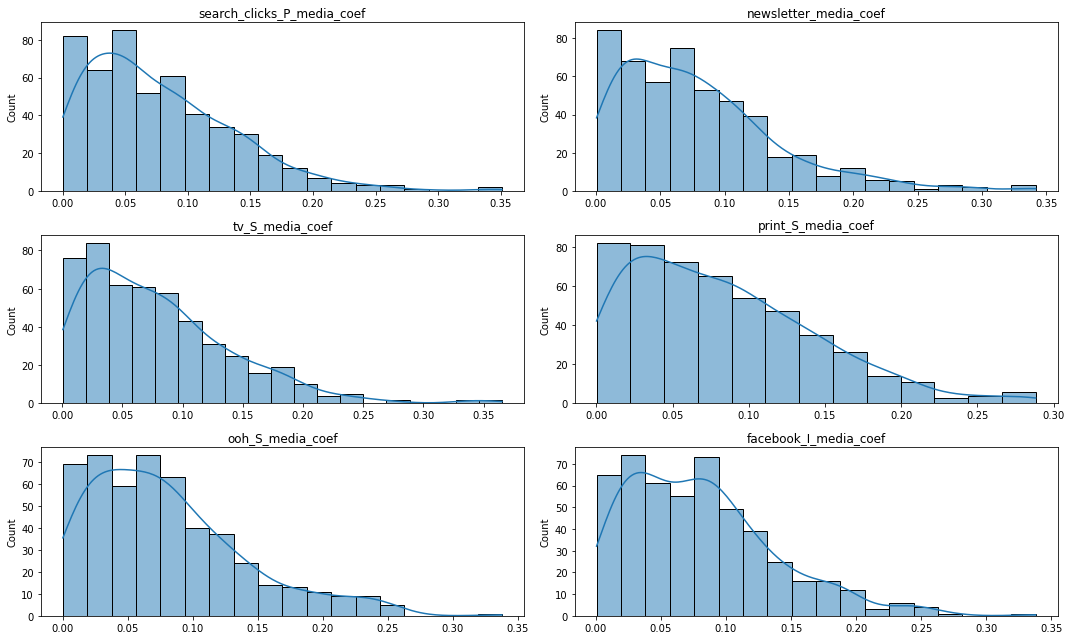

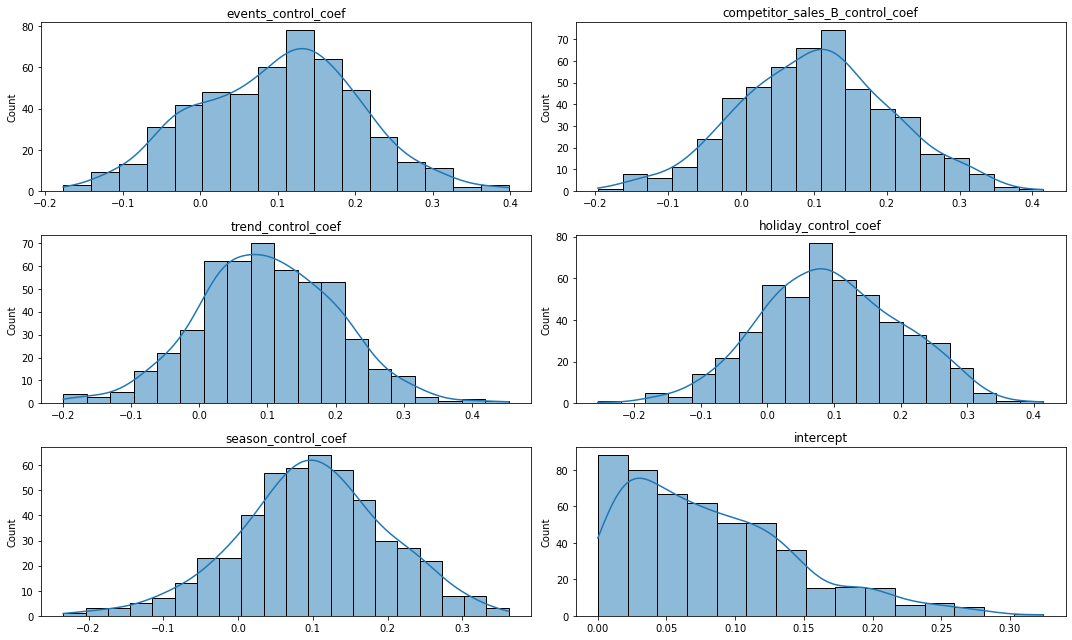

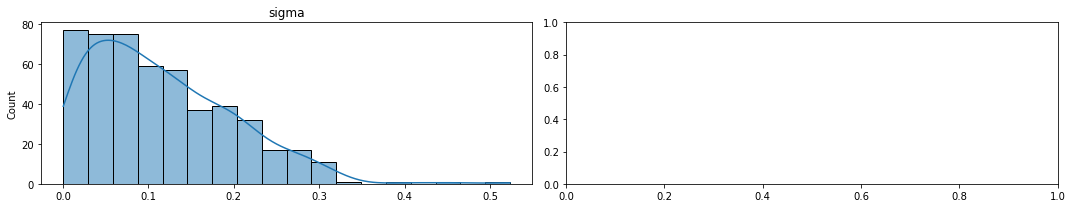

In [114]:
prior_names = [prior_name for prior_name in list(prior_pred.keys()) if (prior_name.endswith("logodds__") == False) & (prior_name.endswith("_log__") == False)]

adstock_priors = [p for p in prior_names if p.endswith("adstock")]
plot_priors(adstock_priors, prior_pred)
print(f"adstock priors: {len(adstock_priors)}")

alpha_priors = [p for p in prior_names if p.endswith("alpha")]
plot_priors(alpha_priors, prior_pred)
print(f"alpha priors: {len(alpha_priors)}")

gamma_priors = [p for p in prior_names if p.endswith("gamma")]
plot_priors(gamma_priors, prior_pred)
print(f"gamma priors: {len(gamma_priors)}")


media_coef_priors = [p for p in prior_names if p.endswith("media_coef")]
plot_priors(media_coef_priors, prior_pred)
print(f"media coef priors: {len(media_coef_priors)}")

control_coef_priors = [p for p in prior_names if p.endswith("control_coef")] + ["intercept"]
plot_priors(control_coef_priors, prior_pred)
print(f"control coef priors: {len(control_coef_priors)}")

plot_priors(["sigma"], prior_pred)
print(f"sigma prior: 1")

### Sample

In [115]:
with model_4:
    trace = pm.sample(1000, tune=1000, step=None, target_accept = 0.95, return_inferencedata=True)
    trace_summary = az.summary(trace)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, intercept, events_control_coef, competitor_sales_B_control_coef, holiday_control_coef, season_control_coef, trend_control_coef, newsletter_media_coef, newsletter_alpha, newsletter_gamma, newsletter_adstock, search_clicks_P_media_coef, search_clicks_P_alpha, search_clicks_P_gamma, search_clicks_P_adstock, facebook_I_media_coef, facebook_I_alpha, facebook_I_gamma, facebook_I_adstock, print_S_media_coef, print_S_alpha, print_S_gamma, print_S_adstock, ooh_S_media_coef, ooh_S_alpha, ooh_S_gamma, ooh_S_adstock, tv_S_media_coef, tv_S_alpha, tv_S_gamma, tv_S_adstock]
INFO:pymc3:NUTS: [sigma, intercept, events_control_coef, competitor_sales_B_control_coef, holiday_control_coef, season_control_coef, trend_control_co

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3684 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3684 seconds.


<AxesSubplot:xlabel='outcome'>

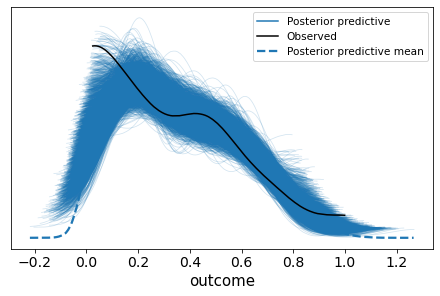

In [116]:
with model_4:
    ppc_all = pm.sample_posterior_predictive(
        trace, var_names=["outcome"] + list(trace_summary.index), random_seed=42
    )
    
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc_all, model=model_3), var_names = ["outcome"])

In [117]:
trace_summary = az.summary(trace)
trace_summary = trace_summary.rename(columns={'mean': 'old_mean'})
trace_summary["mean"] = np.inf


for variable in list(trace_summary.index):
    mean_variable = ppc_all[variable].mean()
    trace_summary.loc[trace_summary.index == variable, "mean"] = mean_variable
	
	
y_true = data[target].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX]
y_pred = dependent_transformation.inverse_transform(ppc_all["outcome"].mean(axis = 0).reshape(-1, 1)).reshape(-1)

print(np.sqrt(np.mean((y_true - y_pred)**2)))
print(np.mean(np.abs((y_true - y_pred) / y_true)))
print(nrmse(y_true, y_pred))


adstock_params = trace_summary[trace_summary.index.str.contains("adstock")][["mean", "sd"]].reset_index().rename(columns = {'index': 'name'}).assign(name = lambda x: x["name"].str.replace("_adstock", ""))
saturation_params = pd.merge(
    trace_summary[trace_summary.index.str.contains("gamma")][["mean"]].reset_index().rename(columns = {'mean': 'gamma'}).assign(name = lambda x: x["index"].str.replace("_gamma", "")), 
    trace_summary[trace_summary.index.str.contains("alpha")][["mean"]].reset_index().rename(columns = {'mean': 'alpha'}).assign(name = lambda x: x["index"].str.replace("_alpha", "")), on = "name" )
control_coefficients = trace_summary[trace_summary.index.str.contains("_control_coef")][["mean", "sd"]].reset_index().assign(name = lambda x: x["index"].str.replace("_control_coef", ""))
delay_coefficients = trace_summary[trace_summary.index.str.contains("_media_coef")][["mean", "sd"]].reset_index().assign(name = lambda x: x["index"].str.replace("_media_coef", ""))


180512.45492543603
0.06782608205450802
0.058584195558867985


### Decomposition

In [118]:
data_transformed_decomposed = data_transformed.copy()
intercept = trace_summary[trace_summary.index == "intercept"]["mean"].iloc[0]
data_transformed_decomposed["intercept"] = intercept
print(f"Intercept: {intercept}")

for delay_channel in delay_channels:
    print(delay_channel)
    
    adstock = adstock_params[adstock_params.name == delay_channel]
    adstock_theta = adstock["mean"].iloc[0]
    
    print(f"\tadstock {adstock_theta} transformation")
    
    data_transformed_decomposed[delay_channel] = adstock_geometric(data_transformed_decomposed[delay_channel].values, theta = adstock_theta)
    
    saturation = saturation_params[saturation_params.name == delay_channel]
    
    saturation_alpha = saturation["alpha"].iloc[0]
    saturation_gamma = saturation["gamma"].iloc[0]
    
    print(f"\tsaturation alpha {saturation_alpha}, gamma {saturation_gamma} transformation")
    
    #use the unbound version of saturation
    data_transformed_decomposed[delay_channel] = saturation_hill_pymc3(data_transformed_decomposed[delay_channel].values, alpha = saturation_alpha, gamma = saturation_gamma)
    
    coefs = delay_coefficients[delay_coefficients.name == delay_channel]
    coef = coefs["mean"].iloc[0]
    
    data_transformed_decomposed[delay_channel] = data_transformed_decomposed[delay_channel] * coef
    print(f"\tcoefficient: {coef}")
    
#apply coefficients

for variable in control_variables:
    coefs = control_coefficients[control_coefficients.name == variable]
    coef = coefs["mean"].iloc[0]
    print(f"Control Coefficient: {variable}: {coef}")
    data_transformed_decomposed[variable] = data_transformed_decomposed[variable] * coef
    
data_transformed_decomposed["prediction"] = data_transformed_decomposed[delay_channels + control_variables + ["intercept"]].sum(axis = 1)
y_pred_decomposed = dependent_transformation.inverse_transform(data_transformed_decomposed["prediction"].values.reshape(-1,1))[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX].reshape(-1)

Intercept: 0.01319760461593027
tv_S
	adstock 0.4328781846576944 transformation
	saturation alpha 2.1336642874206286, gamma 0.4732207450871592 transformation
	coefficient: 0.14934634726113194
ooh_S
	adstock 0.2865405975492281 transformation
	saturation alpha 3.075134351559095, gamma 0.596710549717536 transformation
	coefficient: 0.05085456528953594
print_S
	adstock 0.27040857703219173 transformation
	saturation alpha 2.989358694858185, gamma 0.5409916015360026 transformation
	coefficient: 0.07393543793387324
facebook_I
	adstock 0.21644379003026154 transformation
	saturation alpha 2.733258556459925, gamma 0.609937932362315 transformation
	coefficient: 0.02347093034803621
search_clicks_P
	adstock 0.2021169811888001 transformation
	saturation alpha 3.943658015995584, gamma 0.6801314758458729 transformation
	coefficient: 0.058994373423473405
newsletter
	adstock 0.2790973965345418 transformation
	saturation alpha 4.011519921373777, gamma 0.6772871077257523 transformation
	coefficient: 0.0700

In [119]:
y_true = data[target].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX]
y_pred = dependent_transformation.inverse_transform(ppc_all["outcome"].mean(axis = 0).reshape(-1, 1)).reshape(-1)


print(np.sqrt(np.mean((y_true - y_pred)**2)))
print(np.mean(np.abs((y_true - y_pred) / y_true)))

180512.45492543603
0.06782608205450802


182520.94359662643
0.06478841129677529


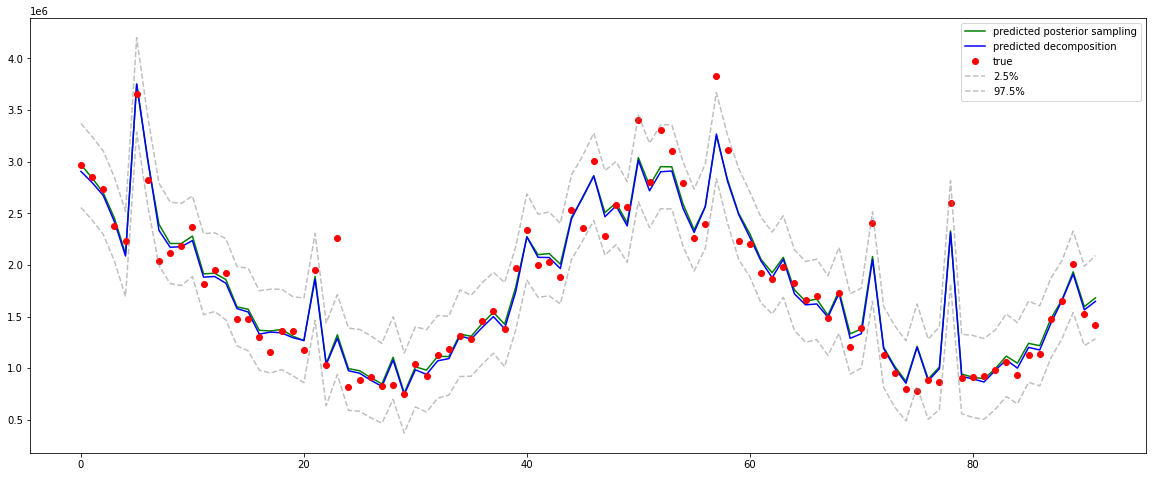

In [120]:
print(np.sqrt(np.mean((y_true - y_pred_decomposed)**2)))
print(np.mean(np.abs((y_true - y_pred_decomposed) / y_true)))

qs = mquantiles(dependent_transformation.inverse_transform(ppc_all["outcome"]), [0.025, 0.975], axis=0)
qs_decomposed = mquantiles(dependent_transformation.inverse_transform(ppc_all["outcome"]), [0.025, 0.975], axis=0)
fig, ax = plt.subplots(figsize = (20, 8))
_ = ax.plot(dependent_transformation.inverse_transform(ppc_all["outcome"].mean(axis = 0).reshape(-1, 1)), color = "green", label = "predicted posterior sampling")
_ = ax.plot(y_pred_decomposed, color = "blue", label = "predicted decomposition")
_ = ax.plot(data[target].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX], 'ro', label = "true")
_ = ax.plot(qs[0], '--', color = "grey", label = "2.5%", alpha = 0.5)
_ = ax.plot(qs[1], '--', color = "grey", label = "97.5%", alpha = 0.5)
_ = ax.legend()

In [121]:
spend_df = pd.DataFrame()
for media_channel in media_channels:
    temp_series = data[media_channel].iloc[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX].values
    #exposure to spend should
    if len(media_spend_exposure_df[media_spend_exposure_df.exposure == media_channel]) > 0:
        
        vmax = media_spend_exposure_df[media_spend_exposure_df.exposure == media_channel]["V_max"].iloc[0]
        km = media_spend_exposure_df[media_spend_exposure_df.exposure == media_channel]["K_m"].iloc[0]
        spends = exposure_to_spend_menten_func(temp_series, V_max = vmax, K_m = km)
        spends_total = spends.sum()
    else:
        spends_total = temp_series.sum()
        
    spend_df = pd.concat([spend_df, pd.DataFrame({'media': [media_channel], 'total_spend': [spends_total]})]).reset_index(drop=True)

spend_df["spend_share"] = spend_df["total_spend"] / spend_df["total_spend"].sum()
spend_df


,media,total_spend,spend_share
0,tv_S,10247935.10000,0.31081
1,ooh_S,10240536.00000,0.31059
2,print_S,2793216.00000,0.08472
3,facebook_I,6031315.27955,0.18293
4,search_clicks_P,3658251.58463,0.11095


In [122]:
response_df = pd.DataFrame()
for media_channel in media_channels:
    response = data_transformed_decomposed[media_channel].iloc[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX].values
    response_total = response.sum()
    
    response_df = pd.concat([response_df, pd.DataFrame({'media': [media_channel], 'total_effect': [response_total]})]).reset_index(drop=True)
response_df["effect_share"] = response_df["total_effect"] / response_df["total_effect"].sum()

response_df


,media,total_effect,effect_share
0,tv_S,1.79732,0.46162
1,ooh_S,0.35981,0.09241
2,print_S,0.68264,0.17533
3,facebook_I,0.21330,0.05478
4,search_clicks_P,0.84041,0.21585


In [123]:
spend_response_share_df = pd.concat([spend_df, response_df.drop(columns=["media"])], axis = 1)
spend_response_share_df

,media,total_spend,spend_share,total_effect,effect_share
0,tv_S,10247935.10000,0.31081,1.79732,0.46162
1,ooh_S,10240536.00000,0.31059,0.35981,0.09241
2,print_S,2793216.00000,0.08472,0.68264,0.17533
3,facebook_I,6031315.27955,0.18293,0.21330,0.05478
4,search_clicks_P,3658251.58463,0.11095,0.84041,0.21585


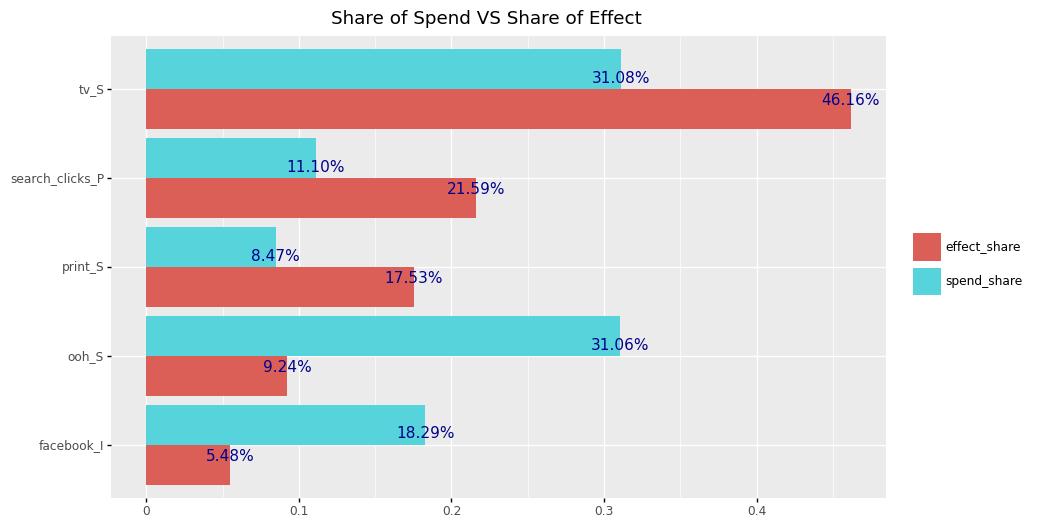

<ggplot: (-9223371869401530080)>

In [124]:
plot_spend_vs_effect_share(spend_response_share_df, figure_size = (10, 6))